# Radial Basis Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
Boston = pd.read_table('Boston.txt', sep=',', dtype=np.float32)
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.199997,4.0900,1.0,296.0,15.300000,396.899994,4.98,24.000000
2.0,0.02731,0.0,7.07,0.0,0.469,6.421,78.900002,4.9671,2.0,242.0,17.799999,396.899994,9.14,21.600000
3.0,0.02729,0.0,7.07,0.0,0.469,7.185,61.099998,4.9671,2.0,242.0,17.799999,392.829987,4.03,34.700001
4.0,0.03237,0.0,2.18,0.0,0.458,6.998,45.799999,6.0622,3.0,222.0,18.700001,394.630005,2.94,33.400002
5.0,0.06905,0.0,2.18,0.0,0.458,7.147,54.200001,6.0622,3.0,222.0,18.700001,396.899994,5.33,36.200001


In [3]:
Boston.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 506 entries, 1.0 to 506.0
Data columns (total 14 columns):
crim       506 non-null float32
zn         506 non-null float32
indus      506 non-null float32
chas       506 non-null float32
nox        506 non-null float32
rm         506 non-null float32
age        506 non-null float32
dis        506 non-null float32
rad        506 non-null float32
tax        506 non-null float32
ptratio    506 non-null float32
black      506 non-null float32
lstat      506 non-null float32
medv       506 non-null float32
dtypes: float32(14)
memory usage: 31.6 KB


In [4]:
Boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613523,11.363636,11.136797,0.069170,0.554696,6.284636,68.574921,3.795043,9.549407,408.237152,18.455584,356.674561,12.653064,22.532806
std,8.601545,23.322390,6.860355,0.253993,0.115878,0.702617,28.148869,2.105711,8.707269,168.537170,2.164946,91.294838,7.141063,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377487,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440002,11.360000,21.200001
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.074999,5.188425,24.000000,666.000000,20.200001,396.225006,16.954999,25.000000
max,88.976196,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.899994,37.970001,50.000000


In [5]:
X_train = Boston.drop('medv', axis=1).loc[:300,:].values
Y_train = Boston.loc[:300,['medv']].values

X_test = Boston.drop('medv', axis=1).loc[300:,:].values
Y_test = Boston.loc[300:,['medv']].values

In [6]:
class Layer1():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def build(self):
        self.weights = []
        self.mu = tf.zeros(shape=(1,self.output_dim), dtype="float32")
        self.sigma = tf.ones(shape=(1,self.output_dim), dtype="float32")

    def __call__(self, inputs):
        return (inputs-self.mu)/self.sigma
    
class Layer2():
    
    def __init__(self, input_dim, output_dim, delta):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.delta = delta
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
    
    def build(self):
        self.l = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.weights = [self.l]
            
    def __call__(self, inputs):
        m = tf.shape(inputs)[0]
        u = tf.repeat(tf.expand_dims(tf.transpose(self.l), axis=0), repeats=m, axis=0)
        x = tf.repeat(tf.expand_dims(inputs, axis=2), repeats=self.output_dim, axis=2)
        z = tf.reduce_sum(tf.square(x-u), axis=1)
        return tf.exp(-z/(2*tf.square(self.delta)))

class Layer3():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()

    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)

    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.weights = [self.w]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) 
        return tf.transpose(z)

In [7]:
class LossFunction():
    
    def __init__(self, model):
        self.model = model

    def __call__(self, y_true, y_pred):
        return tf.math.reduce_mean(tf.math.square(y_true-y_pred))

In [8]:
class MetricFunction():
                    
    def __init__(self, model):
        self.model = model
        
    def __call__(self, y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs(y_true-y_pred))

In [9]:
class Optimizer():

    def __init__(self, model, learning_rate, beta_1, beta_2, epsilon):
        self.model = model
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon= epsilon
        self.stop_training = False
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.zeros(shape=shape, dtype="float32")
        return  tf.Variable(initial_value=weight_init, trainable=False)
    
    def build(self):
        self.weights = []
        for weight in self.model.weights:
            m = self.add_weight(shape=weight.shape)
            v = self.add_weight(shape=weight.shape)
            self.weights.append([m,v])
            
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            m = self.weights[i][0]
            v = self.weights[i][1]
            self.weights[i][0].assign(self.beta_1*m + (1-self.beta_1)*grad_w)  
            self.weights[i][1].assign(self.beta_2*v + (1-self.beta_2)*grad_w*grad_w)
            m_ = (1/(1-self.beta_1))*self.weights[i][0]
            v_ = (1/(1-self.beta_2))*self.weights[i][1]
            weights[i].assign(w - self.learning_rate*m_/(tf.math.sqrt(v_)+self.epsilon))
            
    def train_step(self, X, Y):
        with tf.GradientTape() as tape:
            H = self.model(X)
            loss = self.model.loss(Y, H)
        grads = tape.gradient(loss, self.model.weights)
        self.apply(grads, self.model.weights)
        H = self.model(X)
        loss = self.model.loss(Y, H)
        metric = self.model.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs

In [10]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],
                        'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [11]:
class RBF():
    
    def __init__(self, input_dim, hidden_dim, output_dim, delta=10.):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.delta = delta
        self.build()
    
    def build(self):
        self.h1 = Layer1(input_dim=self.input_dim, output_dim=self.input_dim)
        self.h2 = Layer2(input_dim=self.input_dim, output_dim=self.hidden_dim, delta=self.delta)
        self.h3 = Layer3(input_dim=self.hidden_dim, output_dim=self.output_dim)
        self.layers = [self.h1, self.h2, self.h3]
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):
        a1 = self.h1(inputs)
        a2 = self.h2(a1)
        y = self.h3(a2)
        return y 
        
    def train_setup(self, epochs, learning_rate, beta_1, beta_2, epsilon, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.beta_1 = beta_1 
        self.beta_2 = beta_2 
        self.epsilon = epsilon
        self.verbose = verbose
        self.loss = LossFunction(model=self)
        self.metric = MetricFunction(model=self)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon)
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=1000, error=0.001, reduce_factor=0.1, min_learning_rate=0.0001),
                          Callback4(model=self, patience=2000, error=0.001)]
        
    def fit(self, X, Y, epochs=10000, learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, verbose=True):
        self.layers[0].mu = tf.math.reduce_mean(tf.constant(X, dtype="float32"), axis=0)
        self.layers[0].sigma = tf.math.reduce_std(tf.constant(X, dtype="float32"), axis=0)
        self.train_setup(epochs, learning_rate, beta_1, beta_2, epsilon, verbose)
        if verbose:
            print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(self.epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()

    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [12]:
rbf = RBF(input_dim=X_train.shape[1], hidden_dim=10, output_dim=Y_train.shape[1])

rbf.fit(X_train, Y_train)

Train on 300 samples
Epochs 1/10000 - Loss: 679.4346313476562 - Metric: 24.510452270507812
----- 0.035s -----
Epochs 2/10000 - Loss: 619.2295532226562 - Metric: 23.252811431884766
----- 0.009s -----
Epochs 3/10000 - Loss: 553.1776123046875 - Metric: 21.792011260986328
----- 0.01s -----
Epochs 4/10000 - Loss: 485.792236328125 - Metric: 20.195802688598633
----- 0.011s -----
Epochs 5/10000 - Loss: 420.0622253417969 - Metric: 18.508281707763672
----- 0.01s -----
Epochs 6/10000 - Loss: 358.1052551269531 - Metric: 16.76348876953125
----- 0.01s -----
Epochs 7/10000 - Loss: 301.3536071777344 - Metric: 14.988112449645996
----- 0.009s -----
Epochs 8/10000 - Loss: 250.7195281982422 - Metric: 13.207256317138672
----- 0.01s -----
Epochs 9/10000 - Loss: 206.71336364746094 - Metric: 11.461256980895996
----- 0.009s -----
Epochs 10/10000 - Loss: 169.5267791748047 - Metric: 9.867051124572754
----- 0.009s -----
Epochs 11/10000 - Loss: 139.04994201660156 - Metric: 8.415834426879883
----- 0.009s -----
Epoc

----- 0.009s -----
Epochs 94/10000 - Loss: 32.761539459228516 - Metric: 4.1383819580078125
----- 0.009s -----
Epochs 95/10000 - Loss: 32.708251953125 - Metric: 4.137166976928711
----- 0.01s -----
Epochs 96/10000 - Loss: 32.65548324584961 - Metric: 4.136075973510742
----- 0.008s -----
Epochs 97/10000 - Loss: 32.60321044921875 - Metric: 4.134713172912598
----- 0.008s -----
Epochs 98/10000 - Loss: 32.55136489868164 - Metric: 4.132630825042725
----- 0.009s -----
Epochs 99/10000 - Loss: 32.499874114990234 - Metric: 4.129683494567871
----- 0.01s -----
Epochs 100/10000 - Loss: 32.44874572753906 - Metric: 4.125950813293457
----- 0.011s -----
Epochs 101/10000 - Loss: 32.398006439208984 - Metric: 4.121694564819336
----- 0.01s -----
Epochs 102/10000 - Loss: 32.34769821166992 - Metric: 4.117281436920166
----- 0.01s -----
Epochs 103/10000 - Loss: 32.297813415527344 - Metric: 4.1130852699279785
----- 0.009s -----
Epochs 104/10000 - Loss: 32.24830627441406 - Metric: 4.109395980834961
----- 0.008s ---

----- 0.01s -----
Epochs 185/10000 - Loss: 29.109725952148438 - Metric: 3.9208390712738037
----- 0.009s -----
Epochs 186/10000 - Loss: 29.078895568847656 - Metric: 3.9188830852508545
----- 0.009s -----
Epochs 187/10000 - Loss: 29.048202514648438 - Metric: 3.916943311691284
----- 0.007s -----
Epochs 188/10000 - Loss: 29.017650604248047 - Metric: 3.915020227432251
----- 0.008s -----
Epochs 189/10000 - Loss: 28.987245559692383 - Metric: 3.9131131172180176
----- 0.009s -----
Epochs 190/10000 - Loss: 28.956979751586914 - Metric: 3.9112167358398438
----- 0.01s -----
Epochs 191/10000 - Loss: 28.926855087280273 - Metric: 3.9093265533447266
----- 0.009s -----
Epochs 192/10000 - Loss: 28.89687156677246 - Metric: 3.907437801361084
----- 0.007s -----
Epochs 193/10000 - Loss: 28.86701774597168 - Metric: 3.905547618865967
----- 0.008s -----
Epochs 194/10000 - Loss: 28.837305068969727 - Metric: 3.903658151626587
----- 0.009s -----
Epochs 195/10000 - Loss: 28.807723999023438 - Metric: 3.90176963806152

Epochs 275/10000 - Loss: 26.79740333557129 - Metric: 3.77142333984375
----- 0.007s -----
Epochs 276/10000 - Loss: 26.775915145874023 - Metric: 3.7699882984161377
----- 0.009s -----
Epochs 277/10000 - Loss: 26.754499435424805 - Metric: 3.768557071685791
----- 0.009s -----
Epochs 278/10000 - Loss: 26.733158111572266 - Metric: 3.767129421234131
----- 0.009s -----
Epochs 279/10000 - Loss: 26.711885452270508 - Metric: 3.765705108642578
----- 0.008s -----
Epochs 280/10000 - Loss: 26.690690994262695 - Metric: 3.764285087585449
----- 0.007s -----
Epochs 281/10000 - Loss: 26.669565200805664 - Metric: 3.7628681659698486
----- 0.009s -----
Epochs 282/10000 - Loss: 26.648513793945312 - Metric: 3.7614550590515137
----- 0.01s -----
Epochs 283/10000 - Loss: 26.627531051635742 - Metric: 3.7600460052490234
----- 0.009s -----
Epochs 284/10000 - Loss: 26.606616973876953 - Metric: 3.7586400508880615
----- 0.008s -----
Epochs 285/10000 - Loss: 26.585777282714844 - Metric: 3.7572388648986816
----- 0.007s --

----- 0.011s -----
Epochs 366/10000 - Loss: 25.096616744995117 - Metric: 3.655303955078125
----- 0.01s -----
Epochs 367/10000 - Loss: 25.080331802368164 - Metric: 3.6541800498962402
----- 0.008s -----
Epochs 368/10000 - Loss: 25.0640926361084 - Metric: 3.6530587673187256
----- 0.009s -----
Epochs 369/10000 - Loss: 25.047897338867188 - Metric: 3.6519389152526855
----- 0.009s -----
Epochs 370/10000 - Loss: 25.0317440032959 - Metric: 3.650822639465332
----- 0.009s -----
Epochs 371/10000 - Loss: 25.015642166137695 - Metric: 3.6497087478637695
----- 0.01s -----
Epochs 372/10000 - Loss: 24.999574661254883 - Metric: 3.6485958099365234
----- 0.01s -----
Epochs 373/10000 - Loss: 24.98355484008789 - Metric: 3.6474857330322266
----- 0.009s -----
Epochs 374/10000 - Loss: 24.967578887939453 - Metric: 3.6463778018951416
----- 0.009s -----
Epochs 375/10000 - Loss: 24.951637268066406 - Metric: 3.6452717781066895
----- 0.01s -----
Epochs 376/10000 - Loss: 24.935745239257812 - Metric: 3.6441683769226074

Epochs 456/10000 - Loss: 23.78495216369629 - Metric: 3.5624048709869385
----- 0.01s -----
Epochs 457/10000 - Loss: 23.771900177001953 - Metric: 3.561459541320801
----- 0.008s -----
Epochs 458/10000 - Loss: 23.758880615234375 - Metric: 3.5605156421661377
----- 0.008s -----
Epochs 459/10000 - Loss: 23.745882034301758 - Metric: 3.559573173522949
----- 0.007s -----
Epochs 460/10000 - Loss: 23.7329158782959 - Metric: 3.5586328506469727
----- 0.008s -----
Epochs 461/10000 - Loss: 23.71997833251953 - Metric: 3.5576937198638916
----- 0.008s -----
Epochs 462/10000 - Loss: 23.70707130432129 - Metric: 3.5567562580108643
----- 0.007s -----
Epochs 463/10000 - Loss: 23.694190979003906 - Metric: 3.5558202266693115
----- 0.007s -----
Epochs 464/10000 - Loss: 23.68134117126465 - Metric: 3.55488657951355
----- 0.007s -----
Epochs 465/10000 - Loss: 23.668514251708984 - Metric: 3.5539538860321045
----- 0.007s -----
Epochs 466/10000 - Loss: 23.65572166442871 - Metric: 3.5530223846435547
----- 0.007s -----


Epochs 546/10000 - Loss: 22.714107513427734 - Metric: 3.483260154724121
----- 0.008s -----
Epochs 547/10000 - Loss: 22.70326042175293 - Metric: 3.482445001602173
----- 0.007s -----
Epochs 548/10000 - Loss: 22.69243621826172 - Metric: 3.481630802154541
----- 0.007s -----
Epochs 549/10000 - Loss: 22.68162727355957 - Metric: 3.480818271636963
----- 0.008s -----
Epochs 550/10000 - Loss: 22.670841217041016 - Metric: 3.4800057411193848
----- 0.007s -----
Epochs 551/10000 - Loss: 22.66007423400879 - Metric: 3.4791951179504395
----- 0.007s -----
Epochs 552/10000 - Loss: 22.649330139160156 - Metric: 3.4783854484558105
----- 0.008s -----
Epochs 553/10000 - Loss: 22.638608932495117 - Metric: 3.4775772094726562
----- 0.008s -----
Epochs 554/10000 - Loss: 22.62790298461914 - Metric: 3.4767699241638184
----- 0.008s -----
Epochs 555/10000 - Loss: 22.617216110229492 - Metric: 3.475963830947876
----- 0.007s -----
Epochs 556/10000 - Loss: 22.606550216674805 - Metric: 3.475159168243408
----- 0.008s -----

Epochs 636/10000 - Loss: 21.812395095825195 - Metric: 3.4148848056793213
----- 0.007s -----
Epochs 637/10000 - Loss: 21.803142547607422 - Metric: 3.4141833782196045
----- 0.007s -----
Epochs 638/10000 - Loss: 21.793901443481445 - Metric: 3.413483142852783
----- 0.009s -----
Epochs 639/10000 - Loss: 21.78468132019043 - Metric: 3.4128005504608154
----- 0.008s -----
Epochs 640/10000 - Loss: 21.77547264099121 - Metric: 3.412121534347534
----- 0.007s -----
Epochs 641/10000 - Loss: 21.766281127929688 - Metric: 3.4114434719085693
----- 0.007s -----
Epochs 642/10000 - Loss: 21.75710105895996 - Metric: 3.4107656478881836
----- 0.009s -----
Epochs 643/10000 - Loss: 21.747941970825195 - Metric: 3.4100894927978516
----- 0.009s -----
Epochs 644/10000 - Loss: 21.73879623413086 - Metric: 3.4094138145446777
----- 0.007s -----
Epochs 645/10000 - Loss: 21.729663848876953 - Metric: 3.4087390899658203
----- 0.007s -----
Epochs 646/10000 - Loss: 21.720542907714844 - Metric: 3.408064842224121
----- 0.008s -

Epochs 726/10000 - Loss: 21.0355224609375 - Metric: 3.3566200733184814
----- 0.008s -----
Epochs 727/10000 - Loss: 21.0274715423584 - Metric: 3.3560173511505127
----- 0.008s -----
Epochs 728/10000 - Loss: 21.019432067871094 - Metric: 3.355415105819702
----- 0.007s -----
Epochs 729/10000 - Loss: 21.011404037475586 - Metric: 3.35481333732605
----- 0.007s -----
Epochs 730/10000 - Loss: 21.003389358520508 - Metric: 3.354212760925293
----- 0.009s -----
Epochs 731/10000 - Loss: 20.995386123657227 - Metric: 3.3536133766174316
----- 0.009s -----
Epochs 732/10000 - Loss: 20.987390518188477 - Metric: 3.3530139923095703
----- 0.01s -----
Epochs 733/10000 - Loss: 20.979412078857422 - Metric: 3.3524160385131836
----- 0.008s -----
Epochs 734/10000 - Loss: 20.97144317626953 - Metric: 3.3518173694610596
----- 0.008s -----
Epochs 735/10000 - Loss: 20.963485717773438 - Metric: 3.3512203693389893
----- 0.008s -----
Epochs 736/10000 - Loss: 20.95553970336914 - Metric: 3.3506228923797607
----- 0.009s -----

Epochs 816/10000 - Loss: 20.35431671142578 - Metric: 3.304933786392212
----- 0.009s -----
Epochs 817/10000 - Loss: 20.347204208374023 - Metric: 3.304387331008911
----- 0.01s -----
Epochs 818/10000 - Loss: 20.34010124206543 - Metric: 3.303842782974243
----- 0.01s -----
Epochs 819/10000 - Loss: 20.333003997802734 - Metric: 3.3032987117767334
----- 0.009s -----
Epochs 820/10000 - Loss: 20.32591438293457 - Metric: 3.302755117416382
----- 0.01s -----
Epochs 821/10000 - Loss: 20.3188419342041 - Metric: 3.302212953567505
----- 0.01s -----
Epochs 822/10000 - Loss: 20.3117733001709 - Metric: 3.301670789718628
----- 0.01s -----
Epochs 823/10000 - Loss: 20.304716110229492 - Metric: 3.30112886428833
----- 0.007s -----
Epochs 824/10000 - Loss: 20.297666549682617 - Metric: 3.300589084625244
----- 0.009s -----
Epochs 825/10000 - Loss: 20.29062271118164 - Metric: 3.30005145072937
----- 0.01s -----
Epochs 826/10000 - Loss: 20.283594131469727 - Metric: 3.2995145320892334
----- 0.009s -----
Epochs 827/10

----- 0.008s -----
Epochs 907/10000 - Loss: 19.742237091064453 - Metric: 3.2577600479125977
----- 0.008s -----
Epochs 908/10000 - Loss: 19.735881805419922 - Metric: 3.25726580619812
----- 0.008s -----
Epochs 909/10000 - Loss: 19.729534149169922 - Metric: 3.256772756576538
----- 0.008s -----
Epochs 910/10000 - Loss: 19.723190307617188 - Metric: 3.2562789916992188
----- 0.008s -----
Epochs 911/10000 - Loss: 19.716856002807617 - Metric: 3.255786657333374
----- 0.007s -----
Epochs 912/10000 - Loss: 19.710527420043945 - Metric: 3.255293846130371
----- 0.007s -----
Epochs 913/10000 - Loss: 19.704204559326172 - Metric: 3.25480055809021
----- 0.008s -----
Epochs 914/10000 - Loss: 19.697893142700195 - Metric: 3.2543091773986816
----- 0.007s -----
Epochs 915/10000 - Loss: 19.69158935546875 - Metric: 3.2538180351257324
----- 0.008s -----
Epochs 916/10000 - Loss: 19.685291290283203 - Metric: 3.2533273696899414
----- 0.008s -----
Epochs 917/10000 - Loss: 19.678997039794922 - Metric: 3.2528364658355

----- 0.008s -----
Epochs 997/10000 - Loss: 19.198123931884766 - Metric: 3.2148849964141846
----- 0.007s -----
Epochs 998/10000 - Loss: 19.19237518310547 - Metric: 3.2144298553466797
----- 0.008s -----
Epochs 999/10000 - Loss: 19.186634063720703 - Metric: 3.213974952697754
----- 0.009s -----
Epochs 1000/10000 - Loss: 19.180898666381836 - Metric: 3.2135214805603027
----- 0.008s -----
Epochs 1001/10000 - Loss: 19.1751708984375 - Metric: 3.2130680084228516
----- 0.008s -----
Epochs 1002/10000 - Loss: 19.16944694519043 - Metric: 3.2126145362854004
----- 0.008s -----
Epochs 1003/10000 - Loss: 19.163732528686523 - Metric: 3.2121615409851074
----- 0.007s -----
Epochs 1004/10000 - Loss: 19.15802001953125 - Metric: 3.2117087841033936
----- 0.008s -----
Epochs 1005/10000 - Loss: 19.152318954467773 - Metric: 3.211256504058838
----- 0.007s -----
Epochs 1006/10000 - Loss: 19.146615982055664 - Metric: 3.2108044624328613
----- 0.007s -----
Epochs 1007/10000 - Loss: 19.140926361083984 - Metric: 3.2103

----- 0.008s -----
Epochs 1086/10000 - Loss: 18.709367752075195 - Metric: 3.1764914989471436
----- 0.008s -----
Epochs 1087/10000 - Loss: 18.70412826538086 - Metric: 3.1760787963867188
----- 0.008s -----
Epochs 1088/10000 - Loss: 18.698883056640625 - Metric: 3.175666332244873
----- 0.009s -----
Epochs 1089/10000 - Loss: 18.693649291992188 - Metric: 3.1752543449401855
----- 0.009s -----
Epochs 1090/10000 - Loss: 18.688419342041016 - Metric: 3.174842596054077
----- 0.009s -----
Epochs 1091/10000 - Loss: 18.68319320678711 - Metric: 3.1744308471679688
----- 0.007s -----
Epochs 1092/10000 - Loss: 18.677976608276367 - Metric: 3.1740193367004395
----- 0.008s -----
Epochs 1093/10000 - Loss: 18.672760009765625 - Metric: 3.1736083030700684
----- 0.009s -----
Epochs 1094/10000 - Loss: 18.667552947998047 - Metric: 3.1731975078582764
----- 0.009s -----
Epochs 1095/10000 - Loss: 18.662349700927734 - Metric: 3.1727869510650635
----- 0.009s -----
Epochs 1096/10000 - Loss: 18.657150268554688 - Metric: 

----- 0.007s -----
Epochs 1175/10000 - Loss: 18.26172637939453 - Metric: 3.1409671306610107
----- 0.008s -----
Epochs 1176/10000 - Loss: 18.256908416748047 - Metric: 3.140580177307129
----- 0.007s -----
Epochs 1177/10000 - Loss: 18.252090454101562 - Metric: 3.140193223953247
----- 0.007s -----
Epochs 1178/10000 - Loss: 18.24728012084961 - Metric: 3.1398069858551025
----- 0.007s -----
Epochs 1179/10000 - Loss: 18.242469787597656 - Metric: 3.1394202709198
----- 0.007s -----
Epochs 1180/10000 - Loss: 18.2376651763916 - Metric: 3.1390345096588135
----- 0.007s -----
Epochs 1181/10000 - Loss: 18.232866287231445 - Metric: 3.138648271560669
----- 0.007s -----
Epochs 1182/10000 - Loss: 18.22807502746582 - Metric: 3.1382625102996826
----- 0.008s -----
Epochs 1183/10000 - Loss: 18.223283767700195 - Metric: 3.1378769874572754
----- 0.007s -----
Epochs 1184/10000 - Loss: 18.218494415283203 - Metric: 3.1374921798706055
----- 0.008s -----
Epochs 1185/10000 - Loss: 18.213716506958008 - Metric: 3.13710

Epochs 1264/10000 - Loss: 17.849042892456055 - Metric: 3.1074116230010986
----- 0.009s -----
Epochs 1265/10000 - Loss: 17.844585418701172 - Metric: 3.1070446968078613
----- 0.008s -----
Epochs 1266/10000 - Loss: 17.840129852294922 - Metric: 3.106677770614624
----- 0.009s -----
Epochs 1267/10000 - Loss: 17.835678100585938 - Metric: 3.106313943862915
----- 0.007s -----
Epochs 1268/10000 - Loss: 17.83123207092285 - Metric: 3.1059539318084717
----- 0.008s -----
Epochs 1269/10000 - Loss: 17.82678985595703 - Metric: 3.1055943965911865
----- 0.01s -----
Epochs 1270/10000 - Loss: 17.822349548339844 - Metric: 3.1052353382110596
----- 0.009s -----
Epochs 1271/10000 - Loss: 17.817913055419922 - Metric: 3.1048758029937744
----- 0.009s -----
Epochs 1272/10000 - Loss: 17.81348419189453 - Metric: 3.1045169830322266
----- 0.008s -----
Epochs 1273/10000 - Loss: 17.80905532836914 - Metric: 3.1041581630706787
----- 0.008s -----
Epochs 1274/10000 - Loss: 17.80463218688965 - Metric: 3.103799343109131
-----

----- 0.007s -----
Epochs 1354/10000 - Loss: 17.4622745513916 - Metric: 3.0757429599761963
----- 0.008s -----
Epochs 1355/10000 - Loss: 17.4581356048584 - Metric: 3.075399875640869
----- 0.009s -----
Epochs 1356/10000 - Loss: 17.453998565673828 - Metric: 3.075056552886963
----- 0.009s -----
Epochs 1357/10000 - Loss: 17.449861526489258 - Metric: 3.074713945388794
----- 0.008s -----
Epochs 1358/10000 - Loss: 17.44573211669922 - Metric: 3.0743720531463623
----- 0.007s -----
Epochs 1359/10000 - Loss: 17.441604614257812 - Metric: 3.0740294456481934
----- 0.007s -----
Epochs 1360/10000 - Loss: 17.437480926513672 - Metric: 3.0736868381500244
----- 0.008s -----
Epochs 1361/10000 - Loss: 17.433361053466797 - Metric: 3.0733444690704346
----- 0.007s -----
Epochs 1362/10000 - Loss: 17.429241180419922 - Metric: 3.073002815246582
----- 0.007s -----
Epochs 1363/10000 - Loss: 17.425125122070312 - Metric: 3.0726616382598877
----- 0.007s -----
Epochs 1364/10000 - Loss: 17.4210147857666 - Metric: 3.07232

Epochs 1443/10000 - Loss: 17.106054306030273 - Metric: 3.0458791255950928
----- 0.008s -----
Epochs 1444/10000 - Loss: 17.10218620300293 - Metric: 3.0455515384674072
----- 0.008s -----
Epochs 1445/10000 - Loss: 17.09832191467285 - Metric: 3.045224189758301
----- 0.008s -----
Epochs 1446/10000 - Loss: 17.094465255737305 - Metric: 3.044896125793457
----- 0.007s -----
Epochs 1447/10000 - Loss: 17.09060287475586 - Metric: 3.0445687770843506
----- 0.008s -----
Epochs 1448/10000 - Loss: 17.086746215820312 - Metric: 3.044240951538086
----- 0.008s -----
Epochs 1449/10000 - Loss: 17.08289337158203 - Metric: 3.0439138412475586
----- 0.007s -----
Epochs 1450/10000 - Loss: 17.079044342041016 - Metric: 3.043586492538452
----- 0.007s -----
Epochs 1451/10000 - Loss: 17.075197219848633 - Metric: 3.043259382247925
----- 0.008s -----
Epochs 1452/10000 - Loss: 17.071352005004883 - Metric: 3.0429327487945557
----- 0.009s -----
Epochs 1453/10000 - Loss: 17.0675106048584 - Metric: 3.0426065921783447
----- 0

Epochs 1532/10000 - Loss: 16.772705078125 - Metric: 3.017282485961914
----- 0.008s -----
Epochs 1533/10000 - Loss: 16.769079208374023 - Metric: 3.0169677734375
----- 0.007s -----
Epochs 1534/10000 - Loss: 16.765453338623047 - Metric: 3.0166561603546143
----- 0.009s -----
Epochs 1535/10000 - Loss: 16.7618350982666 - Metric: 3.0163443088531494
----- 0.007s -----
Epochs 1536/10000 - Loss: 16.758216857910156 - Metric: 3.0160324573516846
----- 0.008s -----
Epochs 1537/10000 - Loss: 16.754600524902344 - Metric: 3.0157198905944824
----- 0.008s -----
Epochs 1538/10000 - Loss: 16.750986099243164 - Metric: 3.0154078006744385
----- 0.007s -----
Epochs 1539/10000 - Loss: 16.74737548828125 - Metric: 3.015096664428711
----- 0.007s -----
Epochs 1540/10000 - Loss: 16.7437686920166 - Metric: 3.0147860050201416
----- 0.008s -----
Epochs 1541/10000 - Loss: 16.740161895751953 - Metric: 3.014475107192993
----- 0.007s -----
Epochs 1542/10000 - Loss: 16.73655891418457 - Metric: 3.0141634941101074
----- 0.007

Epochs 1621/10000 - Loss: 16.459575653076172 - Metric: 2.990182399749756
----- 0.007s -----
Epochs 1622/10000 - Loss: 16.456161499023438 - Metric: 2.9898862838745117
----- 0.007s -----
Epochs 1623/10000 - Loss: 16.4527530670166 - Metric: 2.989590644836426
----- 0.007s -----
Epochs 1624/10000 - Loss: 16.449342727661133 - Metric: 2.98929500579834
----- 0.007s -----
Epochs 1625/10000 - Loss: 16.445938110351562 - Metric: 2.988999843597412
----- 0.007s -----
Epochs 1626/10000 - Loss: 16.442535400390625 - Metric: 2.988703966140747
----- 0.008s -----
Epochs 1627/10000 - Loss: 16.43913459777832 - Metric: 2.988408088684082
----- 0.008s -----
Epochs 1628/10000 - Loss: 16.43573570251465 - Metric: 2.9881131649017334
----- 0.007s -----
Epochs 1629/10000 - Loss: 16.43233871459961 - Metric: 2.9878180027008057
----- 0.008s -----
Epochs 1630/10000 - Loss: 16.428943634033203 - Metric: 2.987523078918457
----- 0.008s -----
Epochs 1631/10000 - Loss: 16.42555046081543 - Metric: 2.9872286319732666
----- 0.00

----- 0.008s -----
Epochs 1711/10000 - Loss: 16.161218643188477 - Metric: 2.964282989501953
----- 0.014s -----
Epochs 1712/10000 - Loss: 16.158000946044922 - Metric: 2.9640021324157715
----- 0.008s -----
Epochs 1713/10000 - Loss: 16.154781341552734 - Metric: 2.963721752166748
----- 0.008s -----
Epochs 1714/10000 - Loss: 16.15157127380371 - Metric: 2.963442087173462
----- 0.008s -----
Epochs 1715/10000 - Loss: 16.148353576660156 - Metric: 2.9631614685058594
----- 0.008s -----
Epochs 1716/10000 - Loss: 16.145145416259766 - Metric: 2.9628806114196777
----- 0.007s -----
Epochs 1717/10000 - Loss: 16.141931533813477 - Metric: 2.962599992752075
----- 0.007s -----
Epochs 1718/10000 - Loss: 16.138729095458984 - Metric: 2.96232008934021
----- 0.007s -----
Epochs 1719/10000 - Loss: 16.135520935058594 - Metric: 2.962040662765503
----- 0.007s -----
Epochs 1720/10000 - Loss: 16.1323184967041 - Metric: 2.961760997772217
----- 0.007s -----
Epochs 1721/10000 - Loss: 16.129117965698242 - Metric: 2.96148

----- 0.007s -----
Epochs 1800/10000 - Loss: 15.882379531860352 - Metric: 2.9399073123931885
----- 0.008s -----
Epochs 1801/10000 - Loss: 15.879332542419434 - Metric: 2.939639091491699
----- 0.008s -----
Epochs 1802/10000 - Loss: 15.876287460327148 - Metric: 2.939371109008789
----- 0.008s -----
Epochs 1803/10000 - Loss: 15.873242378234863 - Metric: 2.939103364944458
----- 0.007s -----
Epochs 1804/10000 - Loss: 15.87020206451416 - Metric: 2.938835620880127
----- 0.007s -----
Epochs 1805/10000 - Loss: 15.867161750793457 - Metric: 2.9385690689086914
----- 0.008s -----
Epochs 1806/10000 - Loss: 15.864121437072754 - Metric: 2.9383018016815186
----- 0.007s -----
Epochs 1807/10000 - Loss: 15.861083984375 - Metric: 2.9380340576171875
----- 0.007s -----
Epochs 1808/10000 - Loss: 15.858050346374512 - Metric: 2.9377665519714355
----- 0.007s -----
Epochs 1809/10000 - Loss: 15.85501480102539 - Metric: 2.937499523162842
----- 0.008s -----
Epochs 1810/10000 - Loss: 15.851985931396484 - Metric: 2.9372

----- 0.008s -----
Epochs 1889/10000 - Loss: 15.618056297302246 - Metric: 2.9164464473724365
----- 0.009s -----
Epochs 1890/10000 - Loss: 15.615160942077637 - Metric: 2.916187047958374
----- 0.007s -----
Epochs 1891/10000 - Loss: 15.612274169921875 - Metric: 2.9159276485443115
----- 0.008s -----
Epochs 1892/10000 - Loss: 15.609383583068848 - Metric: 2.915668249130249
----- 0.007s -----
Epochs 1893/10000 - Loss: 15.606493949890137 - Metric: 2.915410041809082
----- 0.009s -----
Epochs 1894/10000 - Loss: 15.603608131408691 - Metric: 2.9151511192321777
----- 0.009s -----
Epochs 1895/10000 - Loss: 15.600724220275879 - Metric: 2.9148926734924316
----- 0.007s -----
Epochs 1896/10000 - Loss: 15.597840309143066 - Metric: 2.9146342277526855
----- 0.007s -----
Epochs 1897/10000 - Loss: 15.594959259033203 - Metric: 2.9143753051757812
----- 0.008s -----
Epochs 1898/10000 - Loss: 15.592082023620605 - Metric: 2.9141175746917725
----- 0.009s -----
Epochs 1899/10000 - Loss: 15.589200973510742 - Metric:

----- 0.007s -----
Epochs 1978/10000 - Loss: 15.366878509521484 - Metric: 2.894134044647217
----- 0.01s -----
Epochs 1979/10000 - Loss: 15.364126205444336 - Metric: 2.8938896656036377
----- 0.01s -----
Epochs 1980/10000 - Loss: 15.361380577087402 - Metric: 2.8936455249786377
----- 0.008s -----
Epochs 1981/10000 - Loss: 15.358626365661621 - Metric: 2.893401622772217
----- 0.008s -----
Epochs 1982/10000 - Loss: 15.355880737304688 - Metric: 2.8931572437286377
----- 0.007s -----
Epochs 1983/10000 - Loss: 15.353133201599121 - Metric: 2.892914056777954
----- 0.007s -----
Epochs 1984/10000 - Loss: 15.350388526916504 - Metric: 2.892671585083008
----- 0.008s -----
Epochs 1985/10000 - Loss: 15.347644805908203 - Metric: 2.8924291133880615
----- 0.007s -----
Epochs 1986/10000 - Loss: 15.344903945922852 - Metric: 2.892186164855957
----- 0.007s -----
Epochs 1987/10000 - Loss: 15.34216594696045 - Metric: 2.8919434547424316
----- 0.007s -----
Epochs 1988/10000 - Loss: 15.33942699432373 - Metric: 2.891

----- 0.007s -----
Epochs 2067/10000 - Loss: 15.127669334411621 - Metric: 2.872791051864624
----- 0.008s -----
Epochs 2068/10000 - Loss: 15.125048637390137 - Metric: 2.8725545406341553
----- 0.009s -----
Epochs 2069/10000 - Loss: 15.122426986694336 - Metric: 2.8723180294036865
----- 0.01s -----
Epochs 2070/10000 - Loss: 15.119804382324219 - Metric: 2.872081756591797
----- 0.009s -----
Epochs 2071/10000 - Loss: 15.117185592651367 - Metric: 2.8718461990356445
----- 0.008s -----
Epochs 2072/10000 - Loss: 15.114566802978516 - Metric: 2.871610403060913
----- 0.007s -----
Epochs 2073/10000 - Loss: 15.111948013305664 - Metric: 2.8713738918304443
----- 0.009s -----
Epochs 2074/10000 - Loss: 15.109333038330078 - Metric: 2.8711376190185547
----- 0.008s -----
Epochs 2075/10000 - Loss: 15.106719970703125 - Metric: 2.8709022998809814
----- 0.007s -----
Epochs 2076/10000 - Loss: 15.104107856750488 - Metric: 2.8706672191619873
----- 0.008s -----
Epochs 2077/10000 - Loss: 15.101497650146484 - Metric: 

----- 0.007s -----
Epochs 2156/10000 - Loss: 14.89941120147705 - Metric: 2.852041006088257
----- 0.007s -----
Epochs 2157/10000 - Loss: 14.896903991699219 - Metric: 2.851811170578003
----- 0.008s -----
Epochs 2158/10000 - Loss: 14.894399642944336 - Metric: 2.851581335067749
----- 0.007s -----
Epochs 2159/10000 - Loss: 14.891894340515137 - Metric: 2.851350784301758
----- 0.007s -----
Epochs 2160/10000 - Loss: 14.889395713806152 - Metric: 2.851121187210083
----- 0.009s -----
Epochs 2161/10000 - Loss: 14.886893272399902 - Metric: 2.8508918285369873
----- 0.008s -----
Epochs 2162/10000 - Loss: 14.884390830993652 - Metric: 2.8506622314453125
----- 0.008s -----
Epochs 2163/10000 - Loss: 14.881893157958984 - Metric: 2.8504323959350586
----- 0.007s -----
Epochs 2164/10000 - Loss: 14.879396438598633 - Metric: 2.8502025604248047
----- 0.007s -----
Epochs 2165/10000 - Loss: 14.876900672912598 - Metric: 2.849973440170288
----- 0.007s -----
Epochs 2166/10000 - Loss: 14.874407768249512 - Metric: 2.8

----- 0.008s -----
Epochs 2245/10000 - Loss: 14.681194305419922 - Metric: 2.8319432735443115
----- 0.008s -----
Epochs 2246/10000 - Loss: 14.67879581451416 - Metric: 2.8317208290100098
----- 0.007s -----
Epochs 2247/10000 - Loss: 14.676400184631348 - Metric: 2.8314993381500244
----- 0.007s -----
Epochs 2248/10000 - Loss: 14.674005508422852 - Metric: 2.831277370452881
----- 0.007s -----
Epochs 2249/10000 - Loss: 14.671606063842773 - Metric: 2.8310554027557373
----- 0.008s -----
Epochs 2250/10000 - Loss: 14.669215202331543 - Metric: 2.8308334350585938
----- 0.008s -----
Epochs 2251/10000 - Loss: 14.666823387145996 - Metric: 2.8306117057800293
----- 0.007s -----
Epochs 2252/10000 - Loss: 14.664435386657715 - Metric: 2.830390453338623
----- 0.008s -----
Epochs 2253/10000 - Loss: 14.662044525146484 - Metric: 2.8301689624786377
----- 0.008s -----
Epochs 2254/10000 - Loss: 14.659658432006836 - Metric: 2.829946994781494
----- 0.007s -----
Epochs 2255/10000 - Loss: 14.657267570495605 - Metric: 

----- 0.008s -----
Epochs 2334/10000 - Loss: 14.472248077392578 - Metric: 2.812735080718994
----- 0.007s -----
Epochs 2335/10000 - Loss: 14.469949722290039 - Metric: 2.8125245571136475
----- 0.007s -----
Epochs 2336/10000 - Loss: 14.467649459838867 - Metric: 2.812314033508301
----- 0.007s -----
Epochs 2337/10000 - Loss: 14.465356826782227 - Metric: 2.812103748321533
----- 0.008s -----
Epochs 2338/10000 - Loss: 14.46306324005127 - Metric: 2.8118929862976074
----- 0.007s -----
Epochs 2339/10000 - Loss: 14.460766792297363 - Metric: 2.8116822242736816
----- 0.009s -----
Epochs 2340/10000 - Loss: 14.458477973937988 - Metric: 2.8114728927612305
----- 0.008s -----
Epochs 2341/10000 - Loss: 14.456183433532715 - Metric: 2.8112618923187256
----- 0.007s -----
Epochs 2342/10000 - Loss: 14.453896522521973 - Metric: 2.8110511302948
----- 0.007s -----
Epochs 2343/10000 - Loss: 14.451604843139648 - Metric: 2.8108410835266113
----- 0.007s -----
Epochs 2344/10000 - Loss: 14.449319839477539 - Metric: 2.8

----- 0.007s -----
Epochs 2423/10000 - Loss: 14.271866798400879 - Metric: 2.794198513031006
----- 0.007s -----
Epochs 2424/10000 - Loss: 14.269662857055664 - Metric: 2.793991804122925
----- 0.007s -----
Epochs 2425/10000 - Loss: 14.267457962036133 - Metric: 2.793785572052002
----- 0.008s -----
Epochs 2426/10000 - Loss: 14.265254020690918 - Metric: 2.7935807704925537
----- 0.008s -----
Epochs 2427/10000 - Loss: 14.263050079345703 - Metric: 2.793375015258789
----- 0.007s -----
Epochs 2428/10000 - Loss: 14.260848045349121 - Metric: 2.793168306350708
----- 0.008s -----
Epochs 2429/10000 - Loss: 14.258650779724121 - Metric: 2.7929630279541016
----- 0.007s -----
Epochs 2430/10000 - Loss: 14.256451606750488 - Metric: 2.792757987976074
----- 0.007s -----
Epochs 2431/10000 - Loss: 14.254253387451172 - Metric: 2.7925527095794678
----- 0.006s -----
Epochs 2432/10000 - Loss: 14.252056121826172 - Metric: 2.792346715927124
----- 0.007s -----
Epochs 2433/10000 - Loss: 14.249858856201172 - Metric: 2.7

----- 0.008s -----
Epochs 2512/10000 - Loss: 14.079437255859375 - Metric: 2.776292324066162
----- 0.007s -----
Epochs 2513/10000 - Loss: 14.077314376831055 - Metric: 2.776095151901245
----- 0.007s -----
Epochs 2514/10000 - Loss: 14.07519817352295 - Metric: 2.775897264480591
----- 0.007s -----
Epochs 2515/10000 - Loss: 14.07308292388916 - Metric: 2.775700569152832
----- 0.008s -----
Epochs 2516/10000 - Loss: 14.070964813232422 - Metric: 2.775503396987915
----- 0.008s -----
Epochs 2517/10000 - Loss: 14.068849563598633 - Metric: 2.775306224822998
----- 0.008s -----
Epochs 2518/10000 - Loss: 14.06673526763916 - Metric: 2.775109052658081
----- 0.008s -----
Epochs 2519/10000 - Loss: 14.064621925354004 - Metric: 2.774911880493164
----- 0.008s -----
Epochs 2520/10000 - Loss: 14.062506675720215 - Metric: 2.774714946746826
----- 0.007s -----
Epochs 2521/10000 - Loss: 14.060397148132324 - Metric: 2.7745180130004883
----- 0.009s -----
Epochs 2522/10000 - Loss: 14.058284759521484 - Metric: 2.774320

----- 0.008s -----
Epochs 2601/10000 - Loss: 13.894404411315918 - Metric: 2.758948564529419
----- 0.007s -----
Epochs 2602/10000 - Loss: 13.892364501953125 - Metric: 2.758756399154663
----- 0.007s -----
Epochs 2603/10000 - Loss: 13.890327453613281 - Metric: 2.7585630416870117
----- 0.008s -----
Epochs 2604/10000 - Loss: 13.888291358947754 - Metric: 2.7583720684051514
----- 0.007s -----
Epochs 2605/10000 - Loss: 13.886253356933594 - Metric: 2.7581801414489746
----- 0.008s -----
Epochs 2606/10000 - Loss: 13.884217262268066 - Metric: 2.7579872608184814
----- 0.007s -----
Epochs 2607/10000 - Loss: 13.882185935974121 - Metric: 2.7577950954437256
----- 0.008s -----
Epochs 2608/10000 - Loss: 13.880152702331543 - Metric: 2.7576041221618652
----- 0.007s -----
Epochs 2609/10000 - Loss: 13.878118515014648 - Metric: 2.7574119567871094
----- 0.007s -----
Epochs 2610/10000 - Loss: 13.87608528137207 - Metric: 2.7572195529937744
----- 0.008s -----
Epochs 2611/10000 - Loss: 13.874053955078125 - Metric:

----- 0.008s -----
Epochs 2690/10000 - Loss: 13.716283798217773 - Metric: 2.7424681186676025
----- 0.007s -----
Epochs 2691/10000 - Loss: 13.71431827545166 - Metric: 2.74228572845459
----- 0.007s -----
Epochs 2692/10000 - Loss: 13.712355613708496 - Metric: 2.742102861404419
----- 0.008s -----
Epochs 2693/10000 - Loss: 13.710393905639648 - Metric: 2.7419204711914062
----- 0.008s -----
Epochs 2694/10000 - Loss: 13.708431243896484 - Metric: 2.74173903465271
----- 0.007s -----
Epochs 2695/10000 - Loss: 13.70647144317627 - Metric: 2.7415566444396973
----- 0.007s -----
Epochs 2696/10000 - Loss: 13.704509735107422 - Metric: 2.7413740158081055
----- 0.008s -----
Epochs 2697/10000 - Loss: 13.702553749084473 - Metric: 2.741191864013672
----- 0.007s -----
Epochs 2698/10000 - Loss: 13.700592041015625 - Metric: 2.7410099506378174
----- 0.007s -----
Epochs 2699/10000 - Loss: 13.698634147644043 - Metric: 2.7408275604248047
----- 0.008s -----
Epochs 2700/10000 - Loss: 13.696680068969727 - Metric: 2.74

----- 0.007s -----
Epochs 2779/10000 - Loss: 13.544625282287598 - Metric: 2.726388692855835
----- 0.007s -----
Epochs 2780/10000 - Loss: 13.542732238769531 - Metric: 2.7262089252471924
----- 0.007s -----
Epochs 2781/10000 - Loss: 13.540840148925781 - Metric: 2.726029634475708
----- 0.008s -----
Epochs 2782/10000 - Loss: 13.538949966430664 - Metric: 2.725851535797119
----- 0.007s -----
Epochs 2783/10000 - Loss: 13.537056922912598 - Metric: 2.725672721862793
----- 0.008s -----
Epochs 2784/10000 - Loss: 13.535167694091797 - Metric: 2.7254936695098877
----- 0.007s -----
Epochs 2785/10000 - Loss: 13.53327751159668 - Metric: 2.7253146171569824
----- 0.008s -----
Epochs 2786/10000 - Loss: 13.531389236450195 - Metric: 2.7251367568969727
----- 0.007s -----
Epochs 2787/10000 - Loss: 13.529499053955078 - Metric: 2.72495698928833
----- 0.008s -----
Epochs 2788/10000 - Loss: 13.527612686157227 - Metric: 2.724778890609741
----- 0.008s -----
Epochs 2789/10000 - Loss: 13.525725364685059 - Metric: 2.72

----- 0.008s -----
Epochs 2868/10000 - Loss: 13.379036903381348 - Metric: 2.7107508182525635
----- 0.009s -----
Epochs 2869/10000 - Loss: 13.377211570739746 - Metric: 2.7105798721313477
----- 0.01s -----
Epochs 2870/10000 - Loss: 13.375385284423828 - Metric: 2.7104086875915527
----- 0.009s -----
Epochs 2871/10000 - Loss: 13.373559951782227 - Metric: 2.7102367877960205
----- 0.008s -----
Epochs 2872/10000 - Loss: 13.371731758117676 - Metric: 2.710066318511963
----- 0.007s -----
Epochs 2873/10000 - Loss: 13.369908332824707 - Metric: 2.7098944187164307
----- 0.007s -----
Epochs 2874/10000 - Loss: 13.368085861206055 - Metric: 2.7097229957580566
----- 0.008s -----
Epochs 2875/10000 - Loss: 13.366263389587402 - Metric: 2.7095530033111572
----- 0.008s -----
Epochs 2876/10000 - Loss: 13.364439010620117 - Metric: 2.709380626678467
----- 0.008s -----
Epochs 2877/10000 - Loss: 13.362616539001465 - Metric: 2.7092089653015137
----- 0.007s -----
Epochs 2878/10000 - Loss: 13.360796928405762 - Metric:

----- 0.008s -----
Epochs 2957/10000 - Loss: 13.219158172607422 - Metric: 2.695629358291626
----- 0.008s -----
Epochs 2958/10000 - Loss: 13.217392921447754 - Metric: 2.695460796356201
----- 0.007s -----
Epochs 2959/10000 - Loss: 13.215627670288086 - Metric: 2.6952924728393555
----- 0.007s -----
Epochs 2960/10000 - Loss: 13.213862419128418 - Metric: 2.6951241493225098
----- 0.008s -----
Epochs 2961/10000 - Loss: 13.2121000289917 - Metric: 2.694955825805664
----- 0.007s -----
Epochs 2962/10000 - Loss: 13.210338592529297 - Metric: 2.6947875022888184
----- 0.007s -----
Epochs 2963/10000 - Loss: 13.208576202392578 - Metric: 2.6946194171905518
----- 0.008s -----
Epochs 2964/10000 - Loss: 13.206815719604492 - Metric: 2.6944515705108643
----- 0.007s -----
Epochs 2965/10000 - Loss: 13.205053329467773 - Metric: 2.6942825317382812
----- 0.007s -----
Epochs 2966/10000 - Loss: 13.203296661376953 - Metric: 2.6941144466400146
----- 0.013s -----
Epochs 2967/10000 - Loss: 13.20153522491455 - Metric: 2.

----- 0.008s -----
Epochs 3046/10000 - Loss: 13.064656257629395 - Metric: 2.6807644367218018
----- 0.008s -----
Epochs 3047/10000 - Loss: 13.062952995300293 - Metric: 2.6805994510650635
----- 0.007s -----
Epochs 3048/10000 - Loss: 13.06124496459961 - Metric: 2.6804325580596924
----- 0.007s -----
Epochs 3049/10000 - Loss: 13.059540748596191 - Metric: 2.6802680492401123
----- 0.009s -----
Epochs 3050/10000 - Loss: 13.057836532592773 - Metric: 2.6801023483276367
----- 0.008s -----
Epochs 3051/10000 - Loss: 13.056132316589355 - Metric: 2.679936408996582
----- 0.007s -----
Epochs 3052/10000 - Loss: 13.054426193237305 - Metric: 2.6797714233398438
----- 0.007s -----
Epochs 3053/10000 - Loss: 13.052725791931152 - Metric: 2.6796064376831055
----- 0.007s -----
Epochs 3054/10000 - Loss: 13.051020622253418 - Metric: 2.6794393062591553
----- 0.008s -----
Epochs 3055/10000 - Loss: 13.049320220947266 - Metric: 2.6792755126953125
----- 0.008s -----
Epochs 3056/10000 - Loss: 13.04762077331543 - Metric:

----- 0.007s -----
Epochs 3135/10000 - Loss: 12.915241241455078 - Metric: 2.6662938594818115
----- 0.007s -----
Epochs 3136/10000 - Loss: 12.913589477539062 - Metric: 2.6661336421966553
----- 0.009s -----
Epochs 3137/10000 - Loss: 12.91193962097168 - Metric: 2.6659739017486572
----- 0.009s -----
Epochs 3138/10000 - Loss: 12.910287857055664 - Metric: 2.66581654548645
----- 0.008s -----
Epochs 3139/10000 - Loss: 12.908638954162598 - Metric: 2.6656553745269775
----- 0.008s -----
Epochs 3140/10000 - Loss: 12.906991004943848 - Metric: 2.665496826171875
----- 0.007s -----
Epochs 3141/10000 - Loss: 12.905343055725098 - Metric: 2.6653387546539307
----- 0.008s -----
Epochs 3142/10000 - Loss: 12.903697967529297 - Metric: 2.6651771068573
----- 0.007s -----
Epochs 3143/10000 - Loss: 12.90204906463623 - Metric: 2.665020227432251
----- 0.007s -----
Epochs 3144/10000 - Loss: 12.900404930114746 - Metric: 2.664860248565674
----- 0.007s -----
Epochs 3145/10000 - Loss: 12.898757934570312 - Metric: 2.6647

----- 0.008s -----
Epochs 3224/10000 - Loss: 12.770634651184082 - Metric: 2.652256965637207
----- 0.007s -----
Epochs 3225/10000 - Loss: 12.769037246704102 - Metric: 2.652101993560791
----- 0.007s -----
Epochs 3226/10000 - Loss: 12.767439842224121 - Metric: 2.651946783065796
----- 0.008s -----
Epochs 3227/10000 - Loss: 12.765839576721191 - Metric: 2.6517910957336426
----- 0.007s -----
Epochs 3228/10000 - Loss: 12.764245986938477 - Metric: 2.651636838912964
----- 0.007s -----
Epochs 3229/10000 - Loss: 12.762648582458496 - Metric: 2.6514811515808105
----- 0.007s -----
Epochs 3230/10000 - Loss: 12.761054992675781 - Metric: 2.651325225830078
----- 0.008s -----
Epochs 3231/10000 - Loss: 12.7594575881958 - Metric: 2.6511712074279785
----- 0.008s -----
Epochs 3232/10000 - Loss: 12.757863998413086 - Metric: 2.651015043258667
----- 0.007s -----
Epochs 3233/10000 - Loss: 12.756269454956055 - Metric: 2.650860548019409
----- 0.007s -----
Epochs 3234/10000 - Loss: 12.754676818847656 - Metric: 2.650

----- 0.008s -----
Epochs 3313/10000 - Loss: 12.630594253540039 - Metric: 2.638536214828491
----- 0.007s -----
Epochs 3314/10000 - Loss: 12.629044532775879 - Metric: 2.6383841037750244
----- 0.007s -----
Epochs 3315/10000 - Loss: 12.627496719360352 - Metric: 2.6382291316986084
----- 0.007s -----
Epochs 3316/10000 - Loss: 12.625950813293457 - Metric: 2.6380786895751953
----- 0.008s -----
Epochs 3317/10000 - Loss: 12.62440299987793 - Metric: 2.6379234790802
----- 0.008s -----
Epochs 3318/10000 - Loss: 12.622856140136719 - Metric: 2.63777232170105
----- 0.009s -----
Epochs 3319/10000 - Loss: 12.621310234069824 - Metric: 2.63761830329895
----- 0.008s -----
Epochs 3320/10000 - Loss: 12.619765281677246 - Metric: 2.6374661922454834
----- 0.007s -----
Epochs 3321/10000 - Loss: 12.618221282958984 - Metric: 2.6373131275177
----- 0.007s -----
Epochs 3322/10000 - Loss: 12.61667537689209 - Metric: 2.637160301208496
----- 0.007s -----
Epochs 3323/10000 - Loss: 12.615132331848145 - Metric: 2.63700771

----- 0.007s -----
Epochs 3402/10000 - Loss: 12.494887351989746 - Metric: 2.6250147819519043
----- 0.007s -----
Epochs 3403/10000 - Loss: 12.493387222290039 - Metric: 2.6248695850372314
----- 0.007s -----
Epochs 3404/10000 - Loss: 12.491886138916016 - Metric: 2.6247122287750244
----- 0.008s -----
Epochs 3405/10000 - Loss: 12.490386009216309 - Metric: 2.6245696544647217
----- 0.007s -----
Epochs 3406/10000 - Loss: 12.488885879516602 - Metric: 2.624408721923828
----- 0.007s -----
Epochs 3407/10000 - Loss: 12.48738956451416 - Metric: 2.624269723892212
----- 0.007s -----
Epochs 3408/10000 - Loss: 12.485892295837402 - Metric: 2.6241068840026855
----- 0.007s -----
Epochs 3409/10000 - Loss: 12.484391212463379 - Metric: 2.623969316482544
----- 0.007s -----
Epochs 3410/10000 - Loss: 12.482894897460938 - Metric: 2.6238036155700684
----- 0.007s -----
Epochs 3411/10000 - Loss: 12.48139762878418 - Metric: 2.6236698627471924
----- 0.008s -----
Epochs 3412/10000 - Loss: 12.479903221130371 - Metric: 2

----- 0.008s -----
Epochs 3491/10000 - Loss: 12.363326072692871 - Metric: 2.6114118099212646
----- 0.008s -----
Epochs 3492/10000 - Loss: 12.361865043640137 - Metric: 2.6115901470184326
----- 0.008s -----
Epochs 3493/10000 - Loss: 12.360420227050781 - Metric: 2.61210298538208
----- 0.007s -----
Epochs 3494/10000 - Loss: 12.358969688415527 - Metric: 2.610593318939209
----- 0.008s -----
Epochs 3495/10000 - Loss: 12.357516288757324 - Metric: 2.6120824813842773
----- 0.008s -----
Epochs 3496/10000 - Loss: 12.356056213378906 - Metric: 2.6104958057403564
----- 0.008s -----
Epochs 3497/10000 - Loss: 12.354596138000488 - Metric: 2.6112372875213623
----- 0.007s -----
Epochs 3498/10000 - Loss: 12.353142738342285 - Metric: 2.6109397411346436
----- 0.007s -----
Epochs 3499/10000 - Loss: 12.351694107055664 - Metric: 2.6102468967437744
----- 0.008s -----
Epochs 3500/10000 - Loss: 12.350250244140625 - Metric: 2.6111395359039307
----- 0.008s -----
Epochs 3501/10000 - Loss: 12.348796844482422 - Metric:

----- 0.007s -----
Epochs 3580/10000 - Loss: 12.235694885253906 - Metric: 2.599182605743408
----- 0.008s -----
Epochs 3581/10000 - Loss: 12.234284400939941 - Metric: 2.59904408454895
----- 0.007s -----
Epochs 3582/10000 - Loss: 12.232870101928711 - Metric: 2.5988998413085938
----- 0.007s -----
Epochs 3583/10000 - Loss: 12.23145866394043 - Metric: 2.598771095275879
----- 0.009s -----
Epochs 3584/10000 - Loss: 12.230049133300781 - Metric: 2.598618984222412
----- 0.007s -----
Epochs 3585/10000 - Loss: 12.228636741638184 - Metric: 2.5984973907470703
----- 0.007s -----
Epochs 3586/10000 - Loss: 12.2272310256958 - Metric: 2.5983405113220215
----- 0.007s -----
Epochs 3587/10000 - Loss: 12.225820541381836 - Metric: 2.5982208251953125
----- 0.007s -----
Epochs 3588/10000 - Loss: 12.224410057067871 - Metric: 2.5980639457702637
----- 0.008s -----
Epochs 3589/10000 - Loss: 12.222997665405273 - Metric: 2.5979416370391846
----- 0.007s -----
Epochs 3590/10000 - Loss: 12.22159481048584 - Metric: 2.597

----- 0.008s -----
Epochs 3669/10000 - Loss: 12.112390518188477 - Metric: 2.5919723510742188
----- 0.007s -----
Epochs 3670/10000 - Loss: 12.111605644226074 - Metric: 2.5796806812286377
----- 0.007s -----
Epochs 3671/10000 - Loss: 12.110257148742676 - Metric: 2.593982219696045
----- 0.007s -----
Epochs 3672/10000 - Loss: 12.108336448669434 - Metric: 2.5812535285949707
----- 0.008s -----
Epochs 3673/10000 - Loss: 12.106428146362305 - Metric: 2.588331937789917
----- 0.007s -----
Epochs 3674/10000 - Loss: 12.105034828186035 - Metric: 2.5878872871398926
----- 0.008s -----
Epochs 3675/10000 - Loss: 12.104034423828125 - Metric: 2.581724166870117
----- 0.008s -----
Epochs 3676/10000 - Loss: 12.102912902832031 - Metric: 2.591499090194702
----- 0.007s -----
Epochs 3677/10000 - Loss: 12.101386070251465 - Metric: 2.5810248851776123
----- 0.007s -----
Epochs 3678/10000 - Loss: 12.09965705871582 - Metric: 2.5883307456970215
----- 0.008s -----
Epochs 3679/10000 - Loss: 12.098136901855469 - Metric: 2

----- 0.007s -----
Epochs 3758/10000 - Loss: 11.991568565368652 - Metric: 2.5748796463012695
----- 0.007s -----
Epochs 3759/10000 - Loss: 11.990235328674316 - Metric: 2.5746889114379883
----- 0.007s -----
Epochs 3760/10000 - Loss: 11.98890495300293 - Metric: 2.5745372772216797
----- 0.008s -----
Epochs 3761/10000 - Loss: 11.987573623657227 - Metric: 2.574479818344116
----- 0.007s -----
Epochs 3762/10000 - Loss: 11.986244201660156 - Metric: 2.574227809906006
----- 0.008s -----
Epochs 3763/10000 - Loss: 11.98491382598877 - Metric: 2.5742223262786865
----- 0.009s -----
Epochs 3764/10000 - Loss: 11.9835844039917 - Metric: 2.573971748352051
----- 0.008s -----
Epochs 3765/10000 - Loss: 11.982255935668945 - Metric: 2.5739171504974365
----- 0.008s -----
Epochs 3766/10000 - Loss: 11.980926513671875 - Metric: 2.573748826980591
----- 0.007s -----
Epochs 3767/10000 - Loss: 11.979599952697754 - Metric: 2.573599338531494
----- 0.009s -----
Epochs 3768/10000 - Loss: 11.978272438049316 - Metric: 2.573

----- 0.007s -----
Epochs 3847/10000 - Loss: 11.874737739562988 - Metric: 2.5628774166107178
----- 0.007s -----
Epochs 3848/10000 - Loss: 11.873443603515625 - Metric: 2.5627613067626953
----- 0.007s -----
Epochs 3849/10000 - Loss: 11.872151374816895 - Metric: 2.562609910964966
----- 0.007s -----
Epochs 3850/10000 - Loss: 11.870862007141113 - Metric: 2.5624983310699463
----- 0.007s -----
Epochs 3851/10000 - Loss: 11.869565963745117 - Metric: 2.5623438358306885
----- 0.009s -----
Epochs 3852/10000 - Loss: 11.868273735046387 - Metric: 2.562235116958618
----- 0.008s -----
Epochs 3853/10000 - Loss: 11.866984367370605 - Metric: 2.562077522277832
----- 0.008s -----
Epochs 3854/10000 - Loss: 11.865692138671875 - Metric: 2.5619728565216064
----- 0.007s -----
Epochs 3855/10000 - Loss: 11.864400863647461 - Metric: 2.561809778213501
----- 0.007s -----
Epochs 3856/10000 - Loss: 11.86310863494873 - Metric: 2.5617117881774902
----- 0.008s -----
Epochs 3857/10000 - Loss: 11.861821174621582 - Metric: 2

----- 0.008s -----
Epochs 3936/10000 - Loss: 11.761237144470215 - Metric: 2.550098180770874
----- 0.008s -----
Epochs 3937/10000 - Loss: 11.759976387023926 - Metric: 2.5520076751708984
----- 0.007s -----
Epochs 3938/10000 - Loss: 11.758703231811523 - Metric: 2.5503242015838623
----- 0.008s -----
Epochs 3939/10000 - Loss: 11.757441520690918 - Metric: 2.550929307937622
----- 0.007s -----
Epochs 3940/10000 - Loss: 11.756187438964844 - Metric: 2.5509774684906006
----- 0.007s -----
Epochs 3941/10000 - Loss: 11.754938125610352 - Metric: 2.54988694190979
----- 0.009s -----
Epochs 3942/10000 - Loss: 11.75368881225586 - Metric: 2.5511932373046875
----- 0.007s -----
Epochs 3943/10000 - Loss: 11.752429962158203 - Metric: 2.5495340824127197
----- 0.008s -----
Epochs 3944/10000 - Loss: 11.75117015838623 - Metric: 2.5506584644317627
----- 0.007s -----
Epochs 3945/10000 - Loss: 11.74991226196289 - Metric: 2.5498104095458984
----- 0.008s -----
Epochs 3946/10000 - Loss: 11.748658180236816 - Metric: 2.5

----- 0.008s -----
Epochs 4025/10000 - Loss: 11.650856971740723 - Metric: 2.5396041870117188
----- 0.007s -----
Epochs 4026/10000 - Loss: 11.649632453918457 - Metric: 2.539501190185547
----- 0.007s -----
Epochs 4027/10000 - Loss: 11.648409843444824 - Metric: 2.5393476486206055
----- 0.008s -----
Epochs 4028/10000 - Loss: 11.647189140319824 - Metric: 2.5392396450042725
----- 0.008s -----
Epochs 4029/10000 - Loss: 11.645967483520508 - Metric: 2.5390939712524414
----- 0.007s -----
Epochs 4030/10000 - Loss: 11.644747734069824 - Metric: 2.538975954055786
----- 0.008s -----
Epochs 4031/10000 - Loss: 11.643524169921875 - Metric: 2.5388412475585938
----- 0.008s -----
Epochs 4032/10000 - Loss: 11.642306327819824 - Metric: 2.538712739944458
----- 0.007s -----
Epochs 4033/10000 - Loss: 11.641082763671875 - Metric: 2.5385875701904297
----- 0.007s -----
Epochs 4034/10000 - Loss: 11.639863967895508 - Metric: 2.538450002670288
----- 0.007s -----
Epochs 4035/10000 - Loss: 11.638647079467773 - Metric: 

----- 0.008s -----
Epochs 4114/10000 - Loss: 11.543661117553711 - Metric: 2.530639886856079
----- 0.007s -----
Epochs 4115/10000 - Loss: 11.542360305786133 - Metric: 2.5273962020874023
----- 0.007s -----
Epochs 4116/10000 - Loss: 11.541176795959473 - Metric: 2.5271806716918945
----- 0.008s -----
Epochs 4117/10000 - Loss: 11.54007339477539 - Metric: 2.5300121307373047
----- 0.009s -----
Epochs 4118/10000 - Loss: 11.538941383361816 - Metric: 2.525181770324707
----- 0.008s -----
Epochs 4119/10000 - Loss: 11.537728309631348 - Metric: 2.530071258544922
----- 0.007s -----
Epochs 4120/10000 - Loss: 11.53646183013916 - Metric: 2.526024580001831
----- 0.008s -----
Epochs 4121/10000 - Loss: 11.535223960876465 - Metric: 2.527745246887207
----- 0.009s -----
Epochs 4122/10000 - Loss: 11.534050941467285 - Metric: 2.5281200408935547
----- 0.008s -----
Epochs 4123/10000 - Loss: 11.532912254333496 - Metric: 2.525522232055664
----- 0.007s -----
Epochs 4124/10000 - Loss: 11.531750679016113 - Metric: 2.52

----- 0.01s -----
Epochs 4203/10000 - Loss: 11.43914794921875 - Metric: 2.51741099357605
----- 0.008s -----
Epochs 4204/10000 - Loss: 11.43799114227295 - Metric: 2.517224073410034
----- 0.007s -----
Epochs 4205/10000 - Loss: 11.436837196350098 - Metric: 2.517148733139038
----- 0.008s -----
Epochs 4206/10000 - Loss: 11.43567943572998 - Metric: 2.517002820968628
----- 0.008s -----
Epochs 4207/10000 - Loss: 11.434523582458496 - Metric: 2.5168817043304443
----- 0.007s -----
Epochs 4208/10000 - Loss: 11.433368682861328 - Metric: 2.516780376434326
----- 0.007s -----
Epochs 4209/10000 - Loss: 11.432212829589844 - Metric: 2.516620635986328
----- 0.009s -----
Epochs 4210/10000 - Loss: 11.43105697631836 - Metric: 2.516549587249756
----- 0.007s -----
Epochs 4211/10000 - Loss: 11.42990493774414 - Metric: 2.516371011734009
----- 0.01s -----
Epochs 4212/10000 - Loss: 11.428752899169922 - Metric: 2.5163068771362305
----- 0.008s -----
Epochs 4213/10000 - Loss: 11.427597999572754 - Metric: 2.5161325931

----- 0.008s -----
Epochs 4292/10000 - Loss: 11.338338851928711 - Metric: 2.5123813152313232
----- 0.008s -----
Epochs 4293/10000 - Loss: 11.337625503540039 - Metric: 2.4999618530273438
----- 0.007s -----
Epochs 4294/10000 - Loss: 11.33703327178955 - Metric: 2.5150773525238037
----- 0.007s -----
Epochs 4295/10000 - Loss: 11.336480140686035 - Metric: 2.4971766471862793
----- 0.009s -----
Epochs 4296/10000 - Loss: 11.335718154907227 - Metric: 2.51700758934021
----- 0.009s -----
Epochs 4297/10000 - Loss: 11.33444881439209 - Metric: 2.496523141860962
----- 0.007s -----
Epochs 4298/10000 - Loss: 11.332538604736328 - Metric: 2.514620065689087
----- 0.007s -----
Epochs 4299/10000 - Loss: 11.330389976501465 - Metric: 2.500809669494629
----- 0.007s -----
Epochs 4300/10000 - Loss: 11.32862663269043 - Metric: 2.5072102546691895
----- 0.007s -----
Epochs 4301/10000 - Loss: 11.327584266662598 - Metric: 2.507920026779175
----- 0.007s -----
Epochs 4302/10000 - Loss: 11.326998710632324 - Metric: 2.500

----- 0.008s -----
Epochs 4381/10000 - Loss: 11.23872184753418 - Metric: 2.4964380264282227
----- 0.008s -----
Epochs 4382/10000 - Loss: 11.237627029418945 - Metric: 2.4964282512664795
----- 0.007s -----
Epochs 4383/10000 - Loss: 11.236530303955078 - Metric: 2.496136426925659
----- 0.009s -----
Epochs 4384/10000 - Loss: 11.235435485839844 - Metric: 2.4962387084960938
----- 0.008s -----
Epochs 4385/10000 - Loss: 11.23434066772461 - Metric: 2.495912551879883
----- 0.008s -----
Epochs 4386/10000 - Loss: 11.233246803283691 - Metric: 2.495974540710449
----- 0.008s -----
Epochs 4387/10000 - Loss: 11.232152938842773 - Metric: 2.49574875831604
----- 0.008s -----
Epochs 4388/10000 - Loss: 11.231058120727539 - Metric: 2.4956769943237305
----- 0.008s -----
Epochs 4389/10000 - Loss: 11.229965209960938 - Metric: 2.495608329772949
----- 0.009s -----
Epochs 4390/10000 - Loss: 11.228873252868652 - Metric: 2.495398998260498
----- 0.007s -----
Epochs 4391/10000 - Loss: 11.22778034210205 - Metric: 2.4954

----- 0.007s -----
Epochs 4470/10000 - Loss: 11.142483711242676 - Metric: 2.4869649410247803
----- 0.007s -----
Epochs 4471/10000 - Loss: 11.141416549682617 - Metric: 2.486877918243408
----- 0.007s -----
Epochs 4472/10000 - Loss: 11.140350341796875 - Metric: 2.4867541790008545
----- 0.008s -----
Epochs 4473/10000 - Loss: 11.13928508758545 - Metric: 2.486668348312378
----- 0.008s -----
Epochs 4474/10000 - Loss: 11.138219833374023 - Metric: 2.4865427017211914
----- 0.007s -----
Epochs 4475/10000 - Loss: 11.137154579162598 - Metric: 2.486459255218506
----- 0.007s -----
Epochs 4476/10000 - Loss: 11.136089324951172 - Metric: 2.4863314628601074
----- 0.009s -----
Epochs 4477/10000 - Loss: 11.135024070739746 - Metric: 2.486250400543213
----- 0.009s -----
Epochs 4478/10000 - Loss: 11.133957862854004 - Metric: 2.4861197471618652
----- 0.009s -----
Epochs 4479/10000 - Loss: 11.132892608642578 - Metric: 2.486042022705078
----- 0.009s -----
Epochs 4480/10000 - Loss: 11.131832122802734 - Metric: 2.

----- 0.007s -----
Epochs 4559/10000 - Loss: 11.048788070678711 - Metric: 2.477421283721924
----- 0.008s -----
Epochs 4560/10000 - Loss: 11.047757148742676 - Metric: 2.4784960746765137
----- 0.007s -----
Epochs 4561/10000 - Loss: 11.04672622680664 - Metric: 2.476656198501587
----- 0.007s -----
Epochs 4562/10000 - Loss: 11.045682907104492 - Metric: 2.478276014328003
----- 0.008s -----
Epochs 4563/10000 - Loss: 11.044634819030762 - Metric: 2.4770259857177734
----- 0.007s -----
Epochs 4564/10000 - Loss: 11.043596267700195 - Metric: 2.4772229194641113
----- 0.007s -----
Epochs 4565/10000 - Loss: 11.042560577392578 - Metric: 2.47770094871521
----- 0.008s -----
Epochs 4566/10000 - Loss: 11.041531562805176 - Metric: 2.476426124572754
----- 0.008s -----
Epochs 4567/10000 - Loss: 11.040491104125977 - Metric: 2.4776957035064697
----- 0.008s -----
Epochs 4568/10000 - Loss: 11.039450645446777 - Metric: 2.47648024559021
----- 0.008s -----
Epochs 4569/10000 - Loss: 11.038410186767578 - Metric: 2.476

----- 0.008s -----
Epochs 4648/10000 - Loss: 10.95753288269043 - Metric: 2.4693119525909424
----- 0.008s -----
Epochs 4649/10000 - Loss: 10.956517219543457 - Metric: 2.4692258834838867
----- 0.007s -----
Epochs 4650/10000 - Loss: 10.955509185791016 - Metric: 2.4691336154937744
----- 0.007s -----
Epochs 4651/10000 - Loss: 10.95449447631836 - Metric: 2.469026565551758
----- 0.008s -----
Epochs 4652/10000 - Loss: 10.953482627868652 - Metric: 2.4689509868621826
----- 0.009s -----
Epochs 4653/10000 - Loss: 10.952475547790527 - Metric: 2.468834400177002
----- 0.008s -----
Epochs 4654/10000 - Loss: 10.95146656036377 - Metric: 2.4687609672546387
----- 0.007s -----
Epochs 4655/10000 - Loss: 10.950454711914062 - Metric: 2.46864914894104
----- 0.007s -----
Epochs 4656/10000 - Loss: 10.949445724487305 - Metric: 2.4685661792755127
----- 0.008s -----
Epochs 4657/10000 - Loss: 10.948436737060547 - Metric: 2.468466281890869
----- 0.008s -----
Epochs 4658/10000 - Loss: 10.947425842285156 - Metric: 2.46

----- 0.007s -----
Epochs 4737/10000 - Loss: 10.868645668029785 - Metric: 2.4614813327789307
----- 0.007s -----
Epochs 4738/10000 - Loss: 10.867661476135254 - Metric: 2.460151433944702
----- 0.007s -----
Epochs 4739/10000 - Loss: 10.866682052612305 - Metric: 2.4615912437438965
----- 0.007s -----
Epochs 4740/10000 - Loss: 10.865703582763672 - Metric: 2.4595863819122314
----- 0.007s -----
Epochs 4741/10000 - Loss: 10.864733695983887 - Metric: 2.461883306503296
----- 0.007s -----
Epochs 4742/10000 - Loss: 10.86376953125 - Metric: 2.4587879180908203
----- 0.008s -----
Epochs 4743/10000 - Loss: 10.862822532653809 - Metric: 2.4624738693237305
----- 0.008s -----
Epochs 4744/10000 - Loss: 10.861896514892578 - Metric: 2.457610607147217
----- 0.007s -----
Epochs 4745/10000 - Loss: 10.861002922058105 - Metric: 2.4635419845581055
----- 0.008s -----
Epochs 4746/10000 - Loss: 10.860161781311035 - Metric: 2.455841064453125
----- 0.008s -----
Epochs 4747/10000 - Loss: 10.859402656555176 - Metric: 2.46

----- 0.008s -----
Epochs 4826/10000 - Loss: 10.782042503356934 - Metric: 2.4525060653686523
----- 0.009s -----
Epochs 4827/10000 - Loss: 10.781084060668945 - Metric: 2.4527206420898438
----- 0.008s -----
Epochs 4828/10000 - Loss: 10.780122756958008 - Metric: 2.452225685119629
----- 0.008s -----
Epochs 4829/10000 - Loss: 10.77916431427002 - Metric: 2.452547788619995
----- 0.009s -----
Epochs 4830/10000 - Loss: 10.77820110321045 - Metric: 2.4521005153656006
----- 0.008s -----
Epochs 4831/10000 - Loss: 10.777244567871094 - Metric: 2.452244997024536
----- 0.007s -----
Epochs 4832/10000 - Loss: 10.776285171508789 - Metric: 2.452061653137207
----- 0.009s -----
Epochs 4833/10000 - Loss: 10.775328636169434 - Metric: 2.451910972595215
----- 0.009s -----
Epochs 4834/10000 - Loss: 10.774368286132812 - Metric: 2.452000141143799
----- 0.008s -----
Epochs 4835/10000 - Loss: 10.773411750793457 - Metric: 2.451643466949463
----- 0.009s -----
Epochs 4836/10000 - Loss: 10.772452354431152 - Metric: 2.451

----- 0.009s -----
Epochs 4915/10000 - Loss: 10.697663307189941 - Metric: 2.444408893585205
----- 0.009s -----
Epochs 4916/10000 - Loss: 10.69672679901123 - Metric: 2.4442813396453857
----- 0.007s -----
Epochs 4917/10000 - Loss: 10.695792198181152 - Metric: 2.4442269802093506
----- 0.008s -----
Epochs 4918/10000 - Loss: 10.694855690002441 - Metric: 2.4440948963165283
----- 0.009s -----
Epochs 4919/10000 - Loss: 10.693920135498047 - Metric: 2.444045305252075
----- 0.009s -----
Epochs 4920/10000 - Loss: 10.692985534667969 - Metric: 2.443906545639038
----- 0.008s -----
Epochs 4921/10000 - Loss: 10.692051887512207 - Metric: 2.4438657760620117
----- 0.007s -----
Epochs 4922/10000 - Loss: 10.691116333007812 - Metric: 2.4437174797058105
----- 0.008s -----
Epochs 4923/10000 - Loss: 10.690184593200684 - Metric: 2.44368839263916
----- 0.008s -----
Epochs 4924/10000 - Loss: 10.689250946044922 - Metric: 2.443525552749634
----- 0.008s -----
Epochs 4925/10000 - Loss: 10.688318252563477 - Metric: 2.4

----- 0.008s -----
Epochs 5004/10000 - Loss: 10.615453720092773 - Metric: 2.4354348182678223
----- 0.007s -----
Epochs 5005/10000 - Loss: 10.614537239074707 - Metric: 2.4368162155151367
----- 0.009s -----
Epochs 5006/10000 - Loss: 10.61362075805664 - Metric: 2.435727834701538
----- 0.009s -----
Epochs 5007/10000 - Loss: 10.612703323364258 - Metric: 2.4359731674194336
----- 0.01s -----
Epochs 5008/10000 - Loss: 10.611796379089355 - Metric: 2.436221122741699
----- 0.009s -----
Epochs 5009/10000 - Loss: 10.610889434814453 - Metric: 2.435265302658081
----- 0.008s -----
Epochs 5010/10000 - Loss: 10.609979629516602 - Metric: 2.436319589614868
----- 0.008s -----
Epochs 5011/10000 - Loss: 10.609067916870117 - Metric: 2.435093879699707
----- 0.008s -----
Epochs 5012/10000 - Loss: 10.608152389526367 - Metric: 2.4358787536621094
----- 0.011s -----
Epochs 5013/10000 - Loss: 10.6072416305542 - Metric: 2.435344696044922
----- 0.01s -----
Epochs 5014/10000 - Loss: 10.606330871582031 - Metric: 2.43521

----- 0.008s -----
Epochs 5093/10000 - Loss: 10.535303115844727 - Metric: 2.428454637527466
----- 0.009s -----
Epochs 5094/10000 - Loss: 10.534417152404785 - Metric: 2.4283699989318848
----- 0.008s -----
Epochs 5095/10000 - Loss: 10.533527374267578 - Metric: 2.4282820224761963
----- 0.009s -----
Epochs 5096/10000 - Loss: 10.532639503479004 - Metric: 2.4281957149505615
----- 0.008s -----
Epochs 5097/10000 - Loss: 10.531749725341797 - Metric: 2.4281115531921387
----- 0.008s -----
Epochs 5098/10000 - Loss: 10.53085994720459 - Metric: 2.428020477294922
----- 0.009s -----
Epochs 5099/10000 - Loss: 10.529973983764648 - Metric: 2.4279417991638184
----- 0.009s -----
Epochs 5100/10000 - Loss: 10.529086112976074 - Metric: 2.4278459548950195
----- 0.009s -----
Epochs 5101/10000 - Loss: 10.528202056884766 - Metric: 2.427771806716919
----- 0.008s -----
Epochs 5102/10000 - Loss: 10.527315139770508 - Metric: 2.427671194076538
----- 0.008s -----
Epochs 5103/10000 - Loss: 10.5264253616333 - Metric: 2.4

----- 0.008s -----
Epochs 5182/10000 - Loss: 10.457850456237793 - Metric: 2.426377534866333
----- 0.008s -----
Epochs 5183/10000 - Loss: 10.457433700561523 - Metric: 2.4141387939453125
----- 0.009s -----
Epochs 5184/10000 - Loss: 10.456255912780762 - Metric: 2.4267446994781494
----- 0.008s -----
Epochs 5185/10000 - Loss: 10.454768180847168 - Metric: 2.4180643558502197
----- 0.009s -----
Epochs 5186/10000 - Loss: 10.453758239746094 - Metric: 2.419668197631836
----- 0.008s -----
Epochs 5187/10000 - Loss: 10.453256607055664 - Metric: 2.4247617721557617
----- 0.017s -----
Epochs 5188/10000 - Loss: 10.452651023864746 - Metric: 2.4152722358703613
----- 0.011s -----
Epochs 5189/10000 - Loss: 10.451574325561523 - Metric: 2.4248459339141846
----- 0.01s -----
Epochs 5190/10000 - Loss: 10.450345993041992 - Metric: 2.418595314025879
----- 0.009s -----
Epochs 5191/10000 - Loss: 10.449438095092773 - Metric: 2.419163465499878
----- 0.008s -----
Epochs 5192/10000 - Loss: 10.448812484741211 - Metric: 2

----- 0.009s -----
Epochs 5271/10000 - Loss: 10.381067276000977 - Metric: 2.413914918899536
----- 0.008s -----
Epochs 5272/10000 - Loss: 10.380221366882324 - Metric: 2.4136717319488525
----- 0.009s -----
Epochs 5273/10000 - Loss: 10.379375457763672 - Metric: 2.413722515106201
----- 0.008s -----
Epochs 5274/10000 - Loss: 10.378532409667969 - Metric: 2.4135711193084717
----- 0.007s -----
Epochs 5275/10000 - Loss: 10.37768840789795 - Metric: 2.413487195968628
----- 0.009s -----
Epochs 5276/10000 - Loss: 10.37684440612793 - Metric: 2.4134764671325684
----- 0.008s -----
Epochs 5277/10000 - Loss: 10.376002311706543 - Metric: 2.4132814407348633
----- 0.008s -----
Epochs 5278/10000 - Loss: 10.375158309936523 - Metric: 2.4133262634277344
----- 0.008s -----
Epochs 5279/10000 - Loss: 10.374317169189453 - Metric: 2.4131412506103516
----- 0.008s -----
Epochs 5280/10000 - Loss: 10.373475074768066 - Metric: 2.4131178855895996
----- 0.009s -----
Epochs 5281/10000 - Loss: 10.372631072998047 - Metric: 2

----- 0.009s -----
Epochs 5360/10000 - Loss: 10.306844711303711 - Metric: 2.406651496887207
----- 0.009s -----
Epochs 5361/10000 - Loss: 10.306021690368652 - Metric: 2.4065780639648438
----- 0.007s -----
Epochs 5362/10000 - Loss: 10.305198669433594 - Metric: 2.4064929485321045
----- 0.009s -----
Epochs 5363/10000 - Loss: 10.304375648498535 - Metric: 2.4064176082611084
----- 0.009s -----
Epochs 5364/10000 - Loss: 10.303552627563477 - Metric: 2.406332015991211
----- 0.008s -----
Epochs 5365/10000 - Loss: 10.30273151397705 - Metric: 2.4062581062316895
----- 0.008s -----
Epochs 5366/10000 - Loss: 10.30190658569336 - Metric: 2.406169891357422
----- 0.007s -----
Epochs 5367/10000 - Loss: 10.301085472106934 - Metric: 2.406097412109375
----- 0.009s -----
Epochs 5368/10000 - Loss: 10.300267219543457 - Metric: 2.4060113430023193
----- 0.009s -----
Epochs 5369/10000 - Loss: 10.299444198608398 - Metric: 2.4059367179870605
----- 0.01s -----
Epochs 5370/10000 - Loss: 10.298624038696289 - Metric: 2.4

----- 0.008s -----
Epochs 5449/10000 - Loss: 10.234554290771484 - Metric: 2.4012999534606934
----- 0.009s -----
Epochs 5450/10000 - Loss: 10.234052658081055 - Metric: 2.3954997062683105
----- 0.008s -----
Epochs 5451/10000 - Loss: 10.233468055725098 - Metric: 2.404508590698242
----- 0.007s -----
Epochs 5452/10000 - Loss: 10.232585906982422 - Metric: 2.3946926593780518
----- 0.009s -----
Epochs 5453/10000 - Loss: 10.231505393981934 - Metric: 2.4023966789245605
----- 0.009s -----
Epochs 5454/10000 - Loss: 10.230491638183594 - Metric: 2.3982200622558594
----- 0.009s -----
Epochs 5455/10000 - Loss: 10.229708671569824 - Metric: 2.3977673053741455
----- 0.009s -----
Epochs 5456/10000 - Loss: 10.229076385498047 - Metric: 2.401991367340088
----- 0.008s -----
Epochs 5457/10000 - Loss: 10.228388786315918 - Metric: 2.3952505588531494
----- 0.007s -----
Epochs 5458/10000 - Loss: 10.227532386779785 - Metric: 2.4022433757781982
----- 0.009s -----
Epochs 5459/10000 - Loss: 10.226576805114746 - Metric

----- 0.009s -----
Epochs 5538/10000 - Loss: 10.163939476013184 - Metric: 2.392557144165039
----- 0.009s -----
Epochs 5539/10000 - Loss: 10.163156509399414 - Metric: 2.3923466205596924
----- 0.008s -----
Epochs 5540/10000 - Loss: 10.162373542785645 - Metric: 2.3923988342285156
----- 0.01s -----
Epochs 5541/10000 - Loss: 10.161590576171875 - Metric: 2.3922064304351807
----- 0.009s -----
Epochs 5542/10000 - Loss: 10.160810470581055 - Metric: 2.3922135829925537
----- 0.009s -----
Epochs 5543/10000 - Loss: 10.160028457641602 - Metric: 2.3920867443084717
----- 0.008s -----
Epochs 5544/10000 - Loss: 10.159246444702148 - Metric: 2.3920180797576904
----- 0.008s -----
Epochs 5545/10000 - Loss: 10.158464431762695 - Metric: 2.3919665813446045
----- 0.008s -----
Epochs 5546/10000 - Loss: 10.157684326171875 - Metric: 2.391831636428833
----- 0.009s -----
Epochs 5547/10000 - Loss: 10.156905174255371 - Metric: 2.3918323516845703
----- 0.009s -----
Epochs 5548/10000 - Loss: 10.156123161315918 - Metric:

----- 0.009s -----
Epochs 5627/10000 - Loss: 10.095170021057129 - Metric: 2.3865249156951904
----- 0.008s -----
Epochs 5628/10000 - Loss: 10.094419479370117 - Metric: 2.3843703269958496
----- 0.007s -----
Epochs 5629/10000 - Loss: 10.093674659729004 - Metric: 2.3868980407714844
----- 0.009s -----
Epochs 5630/10000 - Loss: 10.092942237854004 - Metric: 2.383570909500122
----- 0.009s -----
Epochs 5631/10000 - Loss: 10.092222213745117 - Metric: 2.3875975608825684
----- 0.008s -----
Epochs 5632/10000 - Loss: 10.091533660888672 - Metric: 2.3823721408843994
----- 0.008s -----
Epochs 5633/10000 - Loss: 10.090887069702148 - Metric: 2.3888421058654785
----- 0.008s -----
Epochs 5634/10000 - Loss: 10.090310096740723 - Metric: 2.380556344985962
----- 0.008s -----
Epochs 5635/10000 - Loss: 10.089828491210938 - Metric: 2.3908698558807373
----- 0.01s -----
Epochs 5636/10000 - Loss: 10.089479446411133 - Metric: 2.377993583679199
----- 0.009s -----
Epochs 5637/10000 - Loss: 10.089262008666992 - Metric: 

----- 0.01s -----
Epochs 5716/10000 - Loss: 10.028094291687012 - Metric: 2.3785741329193115
----- 0.009s -----
Epochs 5717/10000 - Loss: 10.027347564697266 - Metric: 2.3788976669311523
----- 0.008s -----
Epochs 5718/10000 - Loss: 10.026605606079102 - Metric: 2.378532886505127
----- 0.007s -----
Epochs 5719/10000 - Loss: 10.025861740112305 - Metric: 2.378593921661377
----- 0.008s -----
Epochs 5720/10000 - Loss: 10.025117874145508 - Metric: 2.3785407543182373
----- 0.01s -----
Epochs 5721/10000 - Loss: 10.024374008178711 - Metric: 2.3783016204833984
----- 0.008s -----
Epochs 5722/10000 - Loss: 10.023632049560547 - Metric: 2.3784873485565186
----- 0.009s -----
Epochs 5723/10000 - Loss: 10.022890090942383 - Metric: 2.378103256225586
----- 0.008s -----
Epochs 5724/10000 - Loss: 10.022147178649902 - Metric: 2.3783252239227295
----- 0.007s -----
Epochs 5725/10000 - Loss: 10.021406173706055 - Metric: 2.3780086040496826
----- 0.009s -----
Epochs 5726/10000 - Loss: 10.02066421508789 - Metric: 2.

----- 0.011s -----
Epochs 5806/10000 - Loss: 9.961977005004883 - Metric: 2.3719613552093506
----- 0.01s -----
Epochs 5807/10000 - Loss: 9.961251258850098 - Metric: 2.371880054473877
----- 0.01s -----
Epochs 5808/10000 - Loss: 9.960524559020996 - Metric: 2.3718109130859375
----- 0.009s -----
Epochs 5809/10000 - Loss: 9.95980167388916 - Metric: 2.371727228164673
----- 0.008s -----
Epochs 5810/10000 - Loss: 9.959075927734375 - Metric: 2.371664524078369
----- 0.008s -----
Epochs 5811/10000 - Loss: 9.958353042602539 - Metric: 2.3715739250183105
----- 0.009s -----
Epochs 5812/10000 - Loss: 9.95762825012207 - Metric: 2.3715169429779053
----- 0.009s -----
Epochs 5813/10000 - Loss: 9.956904411315918 - Metric: 2.3714232444763184
----- 0.009s -----
Epochs 5814/10000 - Loss: 9.95617961883545 - Metric: 2.3713691234588623
----- 0.01s -----
Epochs 5815/10000 - Loss: 9.95545768737793 - Metric: 2.3712713718414307
----- 0.008s -----
Epochs 5816/10000 - Loss: 9.954733848571777 - Metric: 2.371222734451294

Epochs 5896/10000 - Loss: 9.897546768188477 - Metric: 2.3660316467285156
----- 0.008s -----
Epochs 5897/10000 - Loss: 9.896829605102539 - Metric: 2.3648951053619385
----- 0.01s -----
Epochs 5898/10000 - Loss: 9.896120071411133 - Metric: 2.36491322517395
----- 0.01s -----
Epochs 5899/10000 - Loss: 9.895421981811523 - Metric: 2.365642547607422
----- 0.009s -----
Epochs 5900/10000 - Loss: 9.894723892211914 - Metric: 2.364197015762329
----- 0.008s -----
Epochs 5901/10000 - Loss: 9.894014358520508 - Metric: 2.3656299114227295
----- 0.008s -----
Epochs 5902/10000 - Loss: 9.893301963806152 - Metric: 2.364346504211426
----- 0.009s -----
Epochs 5903/10000 - Loss: 9.89259147644043 - Metric: 2.3648688793182373
----- 0.009s -----
Epochs 5904/10000 - Loss: 9.891887664794922 - Metric: 2.364901304244995
----- 0.009s -----
Epochs 5905/10000 - Loss: 9.89118480682373 - Metric: 2.3641202449798584
----- 0.009s -----
Epochs 5906/10000 - Loss: 9.890483856201172 - Metric: 2.3651158809661865
----- 0.008s ----

Epochs 5986/10000 - Loss: 9.83471965789795 - Metric: 2.35866117477417
----- 0.009s -----
Epochs 5987/10000 - Loss: 9.834027290344238 - Metric: 2.358595848083496
----- 0.018s -----
Epochs 5988/10000 - Loss: 9.833340644836426 - Metric: 2.358525514602661
----- 0.01s -----
Epochs 5989/10000 - Loss: 9.83265209197998 - Metric: 2.3584396839141846
----- 0.01s -----
Epochs 5990/10000 - Loss: 9.831966400146484 - Metric: 2.3583884239196777
----- 0.009s -----
Epochs 5991/10000 - Loss: 9.831275939941406 - Metric: 2.358287811279297
----- 0.009s -----
Epochs 5992/10000 - Loss: 9.830585479736328 - Metric: 2.3582451343536377
----- 0.009s -----
Epochs 5993/10000 - Loss: 9.829899787902832 - Metric: 2.3581416606903076
----- 0.008s -----
Epochs 5994/10000 - Loss: 9.829211235046387 - Metric: 2.358097791671753
----- 0.008s -----
Epochs 5995/10000 - Loss: 9.828524589538574 - Metric: 2.357999563217163
----- 0.009s -----
Epochs 5996/10000 - Loss: 9.827838897705078 - Metric: 2.357945680618286
----- 0.01s -----
E

Epochs 6076/10000 - Loss: 9.776171684265137 - Metric: 2.342050075531006
----- 0.009s -----
Epochs 6077/10000 - Loss: 9.774881362915039 - Metric: 2.361260175704956
----- 0.008s -----
Epochs 6078/10000 - Loss: 9.773221969604492 - Metric: 2.345515489578247
----- 0.008s -----
Epochs 6079/10000 - Loss: 9.771711349487305 - Metric: 2.3549647331237793
----- 0.008s -----
Epochs 6080/10000 - Loss: 9.770804405212402 - Metric: 2.352398157119751
----- 0.008s -----
Epochs 6081/10000 - Loss: 9.770488739013672 - Metric: 2.3480255603790283
----- 0.01s -----
Epochs 6082/10000 - Loss: 9.770349502563477 - Metric: 2.3576114177703857
----- 0.009s -----
Epochs 6083/10000 - Loss: 9.769925117492676 - Metric: 2.3449792861938477
----- 0.009s -----
Epochs 6084/10000 - Loss: 9.769020080566406 - Metric: 2.3575165271759033
----- 0.008s -----
Epochs 6085/10000 - Loss: 9.767847061157227 - Metric: 2.347529888153076
----- 0.007s -----
Epochs 6086/10000 - Loss: 9.766816139221191 - Metric: 2.3526461124420166
----- 0.008s 

Epochs 6166/10000 - Loss: 9.713804244995117 - Metric: 2.345728635787964
----- 0.009s -----
Epochs 6167/10000 - Loss: 9.713150978088379 - Metric: 2.3454930782318115
----- 0.008s -----
Epochs 6168/10000 - Loss: 9.712493896484375 - Metric: 2.345532178878784
----- 0.007s -----
Epochs 6169/10000 - Loss: 9.711841583251953 - Metric: 2.345410108566284
----- 0.009s -----
Epochs 6170/10000 - Loss: 9.71118450164795 - Metric: 2.3453257083892822
----- 0.009s -----
Epochs 6171/10000 - Loss: 9.71053409576416 - Metric: 2.3453221321105957
----- 0.009s -----
Epochs 6172/10000 - Loss: 9.709877967834473 - Metric: 2.3451406955718994
----- 0.008s -----
Epochs 6173/10000 - Loss: 9.70922565460205 - Metric: 2.3452022075653076
----- 0.007s -----
Epochs 6174/10000 - Loss: 9.708573341369629 - Metric: 2.3449907302856445
----- 0.008s -----
Epochs 6175/10000 - Loss: 9.707918167114258 - Metric: 2.34504771232605
----- 0.009s -----
Epochs 6176/10000 - Loss: 9.707266807556152 - Metric: 2.344871759414673
----- 0.009s ---

Epochs 6256/10000 - Loss: 9.655632972717285 - Metric: 2.339664936065674
----- 0.008s -----
Epochs 6257/10000 - Loss: 9.65499496459961 - Metric: 2.338524580001831
----- 0.007s -----
Epochs 6258/10000 - Loss: 9.654365539550781 - Metric: 2.339801549911499
----- 0.009s -----
Epochs 6259/10000 - Loss: 9.653733253479004 - Metric: 2.338050603866577
----- 0.009s -----
Epochs 6260/10000 - Loss: 9.653111457824707 - Metric: 2.3401100635528564
----- 0.009s -----
Epochs 6261/10000 - Loss: 9.652496337890625 - Metric: 2.3373711109161377
----- 0.009s -----
Epochs 6262/10000 - Loss: 9.651893615722656 - Metric: 2.3407087326049805
----- 0.008s -----
Epochs 6263/10000 - Loss: 9.651314735412598 - Metric: 2.3363428115844727
----- 0.007s -----
Epochs 6264/10000 - Loss: 9.65077018737793 - Metric: 2.3417813777923584
----- 0.009s -----
Epochs 6265/10000 - Loss: 9.650284767150879 - Metric: 2.334773302078247
----- 0.008s -----
Epochs 6266/10000 - Loss: 9.649887084960938 - Metric: 2.3435845375061035
----- 0.009s -

Epochs 6346/10000 - Loss: 9.5989351272583 - Metric: 2.333197832107544
----- 0.008s -----
Epochs 6347/10000 - Loss: 9.598311424255371 - Metric: 2.3329269886016846
----- 0.007s -----
Epochs 6348/10000 - Loss: 9.59769058227539 - Metric: 2.3328747749328613
----- 0.01s -----
Epochs 6349/10000 - Loss: 9.59706974029541 - Metric: 2.3329710960388184
----- 0.01s -----
Epochs 6350/10000 - Loss: 9.596449851989746 - Metric: 2.332613706588745
----- 0.009s -----
Epochs 6351/10000 - Loss: 9.59582805633545 - Metric: 2.332900047302246
----- 0.008s -----
Epochs 6352/10000 - Loss: 9.595205307006836 - Metric: 2.3324930667877197
----- 0.007s -----
Epochs 6353/10000 - Loss: 9.594585418701172 - Metric: 2.3326923847198486
----- 0.008s -----
Epochs 6354/10000 - Loss: 9.593964576721191 - Metric: 2.33247971534729
----- 0.009s -----
Epochs 6355/10000 - Loss: 9.593342781066895 - Metric: 2.332425117492676
----- 0.01s -----
Epochs 6356/10000 - Loss: 9.59272289276123 - Metric: 2.3324697017669678
----- 0.009s -----
Epo

Epochs 6436/10000 - Loss: 9.543671607971191 - Metric: 2.3271713256835938
----- 0.01s -----
Epochs 6437/10000 - Loss: 9.543067932128906 - Metric: 2.327134370803833
----- 0.009s -----
Epochs 6438/10000 - Loss: 9.542461395263672 - Metric: 2.3270416259765625
----- 0.01s -----
Epochs 6439/10000 - Loss: 9.541855812072754 - Metric: 2.327004909515381
----- 0.01s -----
Epochs 6440/10000 - Loss: 9.541251182556152 - Metric: 2.3269131183624268
----- 0.008s -----
Epochs 6441/10000 - Loss: 9.540644645690918 - Metric: 2.3268752098083496
----- 0.007s -----
Epochs 6442/10000 - Loss: 9.540040016174316 - Metric: 2.3267829418182373
----- 0.01s -----
Epochs 6443/10000 - Loss: 9.539434432983398 - Metric: 2.3267462253570557
----- 0.009s -----
Epochs 6444/10000 - Loss: 9.538830757141113 - Metric: 2.3266537189483643
----- 0.009s -----
Epochs 6445/10000 - Loss: 9.538227081298828 - Metric: 2.3266165256500244
----- 0.01s -----
Epochs 6446/10000 - Loss: 9.537622451782227 - Metric: 2.3265256881713867
----- 0.009s -

Epochs 6526/10000 - Loss: 9.489825248718262 - Metric: 2.321439266204834
----- 0.009s -----
Epochs 6527/10000 - Loss: 9.489243507385254 - Metric: 2.3207015991210938
----- 0.008s -----
Epochs 6528/10000 - Loss: 9.488670349121094 - Metric: 2.322247266769409
----- 0.008s -----
Epochs 6529/10000 - Loss: 9.488083839416504 - Metric: 2.320129871368408
----- 0.008s -----
Epochs 6530/10000 - Loss: 9.4874849319458 - Metric: 2.322007417678833
----- 0.008s -----
Epochs 6531/10000 - Loss: 9.486879348754883 - Metric: 2.3205792903900146
----- 0.009s -----
Epochs 6532/10000 - Loss: 9.486283302307129 - Metric: 2.321023464202881
----- 0.008s -----
Epochs 6533/10000 - Loss: 9.485697746276855 - Metric: 2.321345329284668
----- 0.008s -----
Epochs 6534/10000 - Loss: 9.485116958618164 - Metric: 2.320183038711548
----- 0.007s -----
Epochs 6535/10000 - Loss: 9.484532356262207 - Metric: 2.3215959072113037
----- 0.008s -----
Epochs 6536/10000 - Loss: 9.483942985534668 - Metric: 2.320065498352051
----- 0.008s ----

Epochs 6616/10000 - Loss: 9.437346458435059 - Metric: 2.3156402111053467
----- 0.009s -----
Epochs 6617/10000 - Loss: 9.436772346496582 - Metric: 2.3155996799468994
----- 0.009s -----
Epochs 6618/10000 - Loss: 9.43619441986084 - Metric: 2.3155198097229004
----- 0.008s -----
Epochs 6619/10000 - Loss: 9.43562126159668 - Metric: 2.315469980239868
----- 0.009s -----
Epochs 6620/10000 - Loss: 9.43504524230957 - Metric: 2.315401554107666
----- 0.008s -----
Epochs 6621/10000 - Loss: 9.434473037719727 - Metric: 2.3153388500213623
----- 0.007s -----
Epochs 6622/10000 - Loss: 9.433894157409668 - Metric: 2.315281391143799
----- 0.009s -----
Epochs 6623/10000 - Loss: 9.433320045471191 - Metric: 2.315211296081543
----- 0.009s -----
Epochs 6624/10000 - Loss: 9.432747840881348 - Metric: 2.3151583671569824
----- 0.008s -----
Epochs 6625/10000 - Loss: 9.432173728942871 - Metric: 2.315086841583252
----- 0.008s -----
Epochs 6626/10000 - Loss: 9.431598663330078 - Metric: 2.3150322437286377
----- 0.007s --

----- 0.008s -----
Epochs 6706/10000 - Loss: 9.386282920837402 - Metric: 2.308535099029541
----- 0.007s -----
Epochs 6707/10000 - Loss: 9.38565444946289 - Metric: 2.3095505237579346
----- 0.01s -----
Epochs 6708/10000 - Loss: 9.385229110717773 - Metric: 2.312070608139038
----- 0.008s -----
Epochs 6709/10000 - Loss: 9.38482666015625 - Metric: 2.3067708015441895
----- 0.008s -----
Epochs 6710/10000 - Loss: 9.384283065795898 - Metric: 2.313018321990967
----- 0.008s -----
Epochs 6711/10000 - Loss: 9.383599281311035 - Metric: 2.307269811630249
----- 0.008s -----
Epochs 6712/10000 - Loss: 9.382892608642578 - Metric: 2.3108882904052734
----- 0.009s -----
Epochs 6713/10000 - Loss: 9.382290840148926 - Metric: 2.3098909854888916
----- 0.008s -----
Epochs 6714/10000 - Loss: 9.381799697875977 - Metric: 2.3080568313598633
----- 0.009s -----
Epochs 6715/10000 - Loss: 9.381328582763672 - Metric: 2.311760902404785
----- 0.01s -----
Epochs 6716/10000 - Loss: 9.380784034729004 - Metric: 2.30708622932434

Epochs 6796/10000 - Loss: 9.336389541625977 - Metric: 2.3045668601989746
----- 0.01s -----
Epochs 6797/10000 - Loss: 9.335843086242676 - Metric: 2.304410934448242
----- 0.009s -----
Epochs 6798/10000 - Loss: 9.335298538208008 - Metric: 2.3044402599334717
----- 0.008s -----
Epochs 6799/10000 - Loss: 9.334753036499023 - Metric: 2.304297685623169
----- 0.009s -----
Epochs 6800/10000 - Loss: 9.334205627441406 - Metric: 2.304302453994751
----- 0.008s -----
Epochs 6801/10000 - Loss: 9.333660125732422 - Metric: 2.3041954040527344
----- 0.01s -----
Epochs 6802/10000 - Loss: 9.333115577697754 - Metric: 2.304155111312866
----- 0.01s -----
Epochs 6803/10000 - Loss: 9.332571029663086 - Metric: 2.3040969371795654
----- 0.01s -----
Epochs 6804/10000 - Loss: 9.332023620605469 - Metric: 2.304011821746826
----- 0.009s -----
Epochs 6805/10000 - Loss: 9.331477165222168 - Metric: 2.303990364074707
----- 0.009s -----
Epochs 6806/10000 - Loss: 9.330934524536133 - Metric: 2.303877115249634
----- 0.008s -----

Epochs 6886/10000 - Loss: 9.287975311279297 - Metric: 2.301187515258789
----- 0.008s -----
Epochs 6887/10000 - Loss: 9.287367820739746 - Metric: 2.3004393577575684
----- 0.007s -----
Epochs 6888/10000 - Loss: 9.287291526794434 - Metric: 2.2954039573669434
----- 0.008s -----
Epochs 6889/10000 - Loss: 9.287284851074219 - Metric: 2.304610252380371
----- 0.009s -----
Epochs 6890/10000 - Loss: 9.286906242370605 - Metric: 2.2933876514434814
----- 0.009s -----
Epochs 6891/10000 - Loss: 9.286039352416992 - Metric: 2.3039896488189697
----- 0.007s -----
Epochs 6892/10000 - Loss: 9.284982681274414 - Metric: 2.295916795730591
----- 0.008s -----
Epochs 6893/10000 - Loss: 9.284141540527344 - Metric: 2.2995431423187256
----- 0.008s -----
Epochs 6894/10000 - Loss: 9.28369140625 - Metric: 2.3004908561706543
----- 0.009s -----
Epochs 6895/10000 - Loss: 9.28345775604248 - Metric: 2.2954628467559814
----- 0.011s -----
Epochs 6896/10000 - Loss: 9.283123970031738 - Metric: 2.302858591079712
----- 0.01s ----

Epochs 6976/10000 - Loss: 9.240568161010742 - Metric: 2.29410982131958
----- 0.01s -----
Epochs 6977/10000 - Loss: 9.240045547485352 - Metric: 2.294130563735962
----- 0.008s -----
Epochs 6978/10000 - Loss: 9.239530563354492 - Metric: 2.294050931930542
----- 0.01s -----
Epochs 6979/10000 - Loss: 9.23901081085205 - Metric: 2.293966054916382
----- 0.009s -----
Epochs 6980/10000 - Loss: 9.23849105834961 - Metric: 2.293977975845337
----- 0.007s -----
Epochs 6981/10000 - Loss: 9.237977027893066 - Metric: 2.293823719024658
----- 0.009s -----
Epochs 6982/10000 - Loss: 9.237457275390625 - Metric: 2.2938790321350098
----- 0.009s -----
Epochs 6983/10000 - Loss: 9.236940383911133 - Metric: 2.2937090396881104
----- 0.009s -----
Epochs 6984/10000 - Loss: 9.236422538757324 - Metric: 2.2937533855438232
----- 0.009s -----
Epochs 6985/10000 - Loss: 9.235905647277832 - Metric: 2.293616771697998
----- 0.009s -----
Epochs 6986/10000 - Loss: 9.235387802124023 - Metric: 2.2936129570007324
----- 0.007s -----


Epochs 7066/10000 - Loss: 9.196014404296875 - Metric: 2.2829883098602295
----- 0.009s -----
Epochs 7067/10000 - Loss: 9.196062088012695 - Metric: 2.2966182231903076
----- 0.01s -----
Epochs 7068/10000 - Loss: 9.196087837219238 - Metric: 2.280979871749878
----- 0.01s -----
Epochs 7069/10000 - Loss: 9.195834159851074 - Metric: 2.297827959060669
----- 0.008s -----
Epochs 7070/10000 - Loss: 9.195075988769531 - Metric: 2.2808737754821777
----- 0.007s -----
Epochs 7071/10000 - Loss: 9.193748474121094 - Metric: 2.2958199977874756
----- 0.008s -----
Epochs 7072/10000 - Loss: 9.192231178283691 - Metric: 2.2844362258911133
----- 0.01s -----
Epochs 7073/10000 - Loss: 9.19106388092041 - Metric: 2.2902626991271973
----- 0.009s -----
Epochs 7074/10000 - Loss: 9.190536499023438 - Metric: 2.289989471435547
----- 0.009s -----
Epochs 7075/10000 - Loss: 9.190488815307617 - Metric: 2.2849955558776855
----- 0.008s -----
Epochs 7076/10000 - Loss: 9.190473556518555 - Metric: 2.293823480606079
----- 0.008s --

Epochs 7156/10000 - Loss: 9.149649620056152 - Metric: 2.284106969833374
----- 0.01s -----
Epochs 7157/10000 - Loss: 9.149155616760254 - Metric: 2.284198045730591
----- 0.008s -----
Epochs 7158/10000 - Loss: 9.148662567138672 - Metric: 2.284055471420288
----- 0.008s -----
Epochs 7159/10000 - Loss: 9.148172378540039 - Metric: 2.284027099609375
----- 0.01s -----
Epochs 7160/10000 - Loss: 9.147684097290039 - Metric: 2.284006357192993
----- 0.009s -----
Epochs 7161/10000 - Loss: 9.147191047668457 - Metric: 2.2838683128356934
----- 0.01s -----
Epochs 7162/10000 - Loss: 9.146698951721191 - Metric: 2.2839341163635254
----- 0.01s -----
Epochs 7163/10000 - Loss: 9.146209716796875 - Metric: 2.283738851547241
----- 0.009s -----
Epochs 7164/10000 - Loss: 9.145716667175293 - Metric: 2.2838294506073
----- 0.007s -----
Epochs 7165/10000 - Loss: 9.14522933959961 - Metric: 2.283640146255493
----- 0.008s -----
Epochs 7166/10000 - Loss: 9.144736289978027 - Metric: 2.283698320388794
----- 0.01s -----
Epoch

Epochs 7246/10000 - Loss: 9.106191635131836 - Metric: 2.2769172191619873
----- 0.007s -----
Epochs 7247/10000 - Loss: 9.105847358703613 - Metric: 2.282261848449707
----- 0.007s -----
Epochs 7248/10000 - Loss: 9.10558032989502 - Metric: 2.275425910949707
----- 0.009s -----
Epochs 7249/10000 - Loss: 9.105422019958496 - Metric: 2.2838516235351562
----- 0.01s -----
Epochs 7250/10000 - Loss: 9.10540771484375 - Metric: 2.273306369781494
----- 0.009s -----
Epochs 7251/10000 - Loss: 9.105533599853516 - Metric: 2.2861168384552
----- 0.009s -----
Epochs 7252/10000 - Loss: 9.105737686157227 - Metric: 2.270916223526001
----- 0.007s -----
Epochs 7253/10000 - Loss: 9.105775833129883 - Metric: 2.2879908084869385
----- 0.008s -----
Epochs 7254/10000 - Loss: 9.105332374572754 - Metric: 2.270005226135254
----- 0.009s -----
Epochs 7255/10000 - Loss: 9.104145050048828 - Metric: 2.286818504333496
----- 0.009s -----
Epochs 7256/10000 - Loss: 9.102481842041016 - Metric: 2.273094892501831
----- 0.009s -----
E

Epochs 7336/10000 - Loss: 9.063424110412598 - Metric: 2.2744855880737305
----- 0.009s -----
Epochs 7337/10000 - Loss: 9.062960624694824 - Metric: 2.274366855621338
----- 0.009s -----
Epochs 7338/10000 - Loss: 9.062494277954102 - Metric: 2.274456262588501
----- 0.007s -----
Epochs 7339/10000 - Loss: 9.062028884887695 - Metric: 2.2742109298706055
----- 0.008s -----
Epochs 7340/10000 - Loss: 9.061561584472656 - Metric: 2.2743654251098633
----- 0.007s -----
Epochs 7341/10000 - Loss: 9.061097145080566 - Metric: 2.2741193771362305
----- 0.008s -----
Epochs 7342/10000 - Loss: 9.060629844665527 - Metric: 2.274216413497925
----- 0.009s -----
Epochs 7343/10000 - Loss: 9.060166358947754 - Metric: 2.2740721702575684
----- 0.008s -----
Epochs 7344/10000 - Loss: 9.059698104858398 - Metric: 2.2740418910980225
----- 0.009s -----
Epochs 7345/10000 - Loss: 9.059234619140625 - Metric: 2.2740285396575928
----- 0.008s -----
Epochs 7346/10000 - Loss: 9.058768272399902 - Metric: 2.2738842964172363
----- 0.00

Epochs 7426/10000 - Loss: 9.022006034851074 - Metric: 2.26969313621521
----- 0.01s -----
Epochs 7427/10000 - Loss: 9.021553993225098 - Metric: 2.269587516784668
----- 0.008s -----
Epochs 7428/10000 - Loss: 9.021103858947754 - Metric: 2.2695939540863037
----- 0.007s -----
Epochs 7429/10000 - Loss: 9.020645141601562 - Metric: 2.2694737911224365
----- 0.008s -----
Epochs 7430/10000 - Loss: 9.020194053649902 - Metric: 2.2694973945617676
----- 0.008s -----
Epochs 7431/10000 - Loss: 9.019739151000977 - Metric: 2.2693541049957275
----- 0.009s -----
Epochs 7432/10000 - Loss: 9.01928424835205 - Metric: 2.2694079875946045
----- 0.009s -----
Epochs 7433/10000 - Loss: 9.018835067749023 - Metric: 2.269226312637329
----- 0.009s -----
Epochs 7434/10000 - Loss: 9.018377304077148 - Metric: 2.26932954788208
----- 0.009s -----
Epochs 7435/10000 - Loss: 9.017928123474121 - Metric: 2.2690837383270264
----- 0.008s -----
Epochs 7436/10000 - Loss: 9.017475128173828 - Metric: 2.26926851272583
----- 0.007s ----

Epochs 7516/10000 - Loss: 8.981698036193848 - Metric: 2.2651331424713135
----- 0.007s -----
Epochs 7517/10000 - Loss: 8.981255531311035 - Metric: 2.2649643421173096
----- 0.009s -----
Epochs 7518/10000 - Loss: 8.980814933776855 - Metric: 2.2646584510803223
----- 0.008s -----
Epochs 7519/10000 - Loss: 8.980376243591309 - Metric: 2.265131950378418
----- 0.009s -----
Epochs 7520/10000 - Loss: 8.979934692382812 - Metric: 2.264442205429077
----- 0.009s -----
Epochs 7521/10000 - Loss: 8.979491233825684 - Metric: 2.264974355697632
----- 0.008s -----
Epochs 7522/10000 - Loss: 8.979049682617188 - Metric: 2.2645301818847656
----- 0.008s -----
Epochs 7523/10000 - Loss: 8.978607177734375 - Metric: 2.264604330062866
----- 0.009s -----
Epochs 7524/10000 - Loss: 8.978167533874512 - Metric: 2.2646985054016113
----- 0.008s -----
Epochs 7525/10000 - Loss: 8.977727890014648 - Metric: 2.264293909072876
----- 0.009s -----
Epochs 7526/10000 - Loss: 8.977286338806152 - Metric: 2.2646989822387695
----- 0.008s

Epochs 7606/10000 - Loss: 8.94245433807373 - Metric: 2.2603867053985596
----- 0.008s -----
Epochs 7607/10000 - Loss: 8.942024230957031 - Metric: 2.260317802429199
----- 0.008s -----
Epochs 7608/10000 - Loss: 8.941596031188965 - Metric: 2.2602837085723877
----- 0.008s -----
Epochs 7609/10000 - Loss: 8.941165924072266 - Metric: 2.2602193355560303
----- 0.009s -----
Epochs 7610/10000 - Loss: 8.9407377243042 - Metric: 2.2601776123046875
----- 0.009s -----
Epochs 7611/10000 - Loss: 8.94030475616455 - Metric: 2.2601232528686523
----- 0.009s -----
Epochs 7612/10000 - Loss: 8.9398775100708 - Metric: 2.2600698471069336
----- 0.009s -----
Epochs 7613/10000 - Loss: 8.939449310302734 - Metric: 2.260026454925537
----- 0.007s -----
Epochs 7614/10000 - Loss: 8.939018249511719 - Metric: 2.25996470451355
----- 0.009s -----
Epochs 7615/10000 - Loss: 8.938590049743652 - Metric: 2.2599263191223145
----- 0.009s -----
Epochs 7616/10000 - Loss: 8.938161849975586 - Metric: 2.2598648071289062
----- 0.009s ----

----- 0.008s -----
Epochs 7696/10000 - Loss: 8.904498100280762 - Metric: 2.2581276893615723
----- 0.008s -----
Epochs 7697/10000 - Loss: 8.904219627380371 - Metric: 2.253234386444092
----- 0.008s -----
Epochs 7698/10000 - Loss: 8.903748512268066 - Metric: 2.2584052085876465
----- 0.009s -----
Epochs 7699/10000 - Loss: 8.903156280517578 - Metric: 2.2541394233703613
----- 0.009s -----
Epochs 7700/10000 - Loss: 8.902605056762695 - Metric: 2.256265878677368
----- 0.009s -----
Epochs 7701/10000 - Loss: 8.90219783782959 - Metric: 2.256394863128662
----- 0.008s -----
Epochs 7702/10000 - Loss: 8.901884078979492 - Metric: 2.2540931701660156
----- 0.008s -----
Epochs 7703/10000 - Loss: 8.90153980255127 - Metric: 2.25761079788208
----- 0.009s -----
Epochs 7704/10000 - Loss: 8.901092529296875 - Metric: 2.2537460327148438
----- 0.009s -----
Epochs 7705/10000 - Loss: 8.900581359863281 - Metric: 2.256746530532837
----- 0.008s -----
Epochs 7706/10000 - Loss: 8.900092124938965 - Metric: 2.2551081180572

----- 0.008s -----
Epochs 7786/10000 - Loss: 8.867105484008789 - Metric: 2.2516913414001465
----- 0.01s -----
Epochs 7787/10000 - Loss: 8.866700172424316 - Metric: 2.251616954803467
----- 0.01s -----
Epochs 7788/10000 - Loss: 8.866291999816895 - Metric: 2.2515738010406494
----- 0.009s -----
Epochs 7789/10000 - Loss: 8.865885734558105 - Metric: 2.2515437602996826
----- 0.009s -----
Epochs 7790/10000 - Loss: 8.865477561950684 - Metric: 2.2514586448669434
----- 0.01s -----
Epochs 7791/10000 - Loss: 8.865072250366211 - Metric: 2.2514660358428955
----- 0.01s -----
Epochs 7792/10000 - Loss: 8.864665985107422 - Metric: 2.251350164413452
----- 0.008s -----
Epochs 7793/10000 - Loss: 8.864258766174316 - Metric: 2.2513790130615234
----- 0.008s -----
Epochs 7794/10000 - Loss: 8.863852500915527 - Metric: 2.2512545585632324
----- 0.007s -----
Epochs 7795/10000 - Loss: 8.863444328308105 - Metric: 2.2512762546539307
----- 0.009s -----
Epochs 7796/10000 - Loss: 8.86303997039795 - Metric: 2.251173496246

----- 0.01s -----
Epochs 7876/10000 - Loss: 8.832200050354004 - Metric: 2.242642879486084
----- 0.009s -----
Epochs 7877/10000 - Loss: 8.832523345947266 - Metric: 2.253504753112793
----- 0.008s -----
Epochs 7878/10000 - Loss: 8.833088874816895 - Metric: 2.240110158920288
----- 0.007s -----
Epochs 7879/10000 - Loss: 8.833681106567383 - Metric: 2.256133556365967
----- 0.008s -----
Epochs 7880/10000 - Loss: 8.833853721618652 - Metric: 2.238382339477539
----- 0.009s -----
Epochs 7881/10000 - Loss: 8.832948684692383 - Metric: 2.256105661392212
----- 0.008s -----
Epochs 7882/10000 - Loss: 8.830976486206055 - Metric: 2.2405714988708496
----- 0.008s -----
Epochs 7883/10000 - Loss: 8.828848838806152 - Metric: 2.2506425380706787
----- 0.008s -----
Epochs 7884/10000 - Loss: 8.82778549194336 - Metric: 2.2471165657043457
----- 0.012s -----
Epochs 7885/10000 - Loss: 8.827998161315918 - Metric: 2.243622303009033
----- 0.009s -----
Epochs 7886/10000 - Loss: 8.828615188598633 - Metric: 2.25248169898986

----- 0.011s -----
Epochs 7966/10000 - Loss: 8.795790672302246 - Metric: 2.243366003036499
----- 0.009s -----
Epochs 7967/10000 - Loss: 8.79540729522705 - Metric: 2.2431302070617676
----- 0.008s -----
Epochs 7968/10000 - Loss: 8.79502010345459 - Metric: 2.243236541748047
----- 0.008s -----
Epochs 7969/10000 - Loss: 8.794635772705078 - Metric: 2.243107795715332
----- 0.01s -----
Epochs 7970/10000 - Loss: 8.794251441955566 - Metric: 2.243067979812622
----- 0.009s -----
Epochs 7971/10000 - Loss: 8.793865203857422 - Metric: 2.2430896759033203
----- 0.009s -----
Epochs 7972/10000 - Loss: 8.79348087310791 - Metric: 2.2429258823394775
----- 0.01s -----
Epochs 7973/10000 - Loss: 8.793096542358398 - Metric: 2.243021011352539
----- 0.008s -----
Epochs 7974/10000 - Loss: 8.792712211608887 - Metric: 2.242844343185425
----- 0.009s -----
Epochs 7975/10000 - Loss: 8.792327880859375 - Metric: 2.242896795272827
----- 0.008s -----
Epochs 7976/10000 - Loss: 8.791942596435547 - Metric: 2.2428042888641357


----- 0.007s -----
Epochs 8056/10000 - Loss: 8.761588096618652 - Metric: 2.239212989807129
----- 0.008s -----
Epochs 8057/10000 - Loss: 8.761213302612305 - Metric: 2.239184617996216
----- 0.009s -----
Epochs 8058/10000 - Loss: 8.760839462280273 - Metric: 2.2391293048858643
----- 0.008s -----
Epochs 8059/10000 - Loss: 8.760464668273926 - Metric: 2.2390904426574707
----- 0.009s -----
Epochs 8060/10000 - Loss: 8.760091781616211 - Metric: 2.2390449047088623
----- 0.01s -----
Epochs 8061/10000 - Loss: 8.759714126586914 - Metric: 2.2389957904815674
----- 0.008s -----
Epochs 8062/10000 - Loss: 8.7593412399292 - Metric: 2.238959789276123
----- 0.008s -----
Epochs 8063/10000 - Loss: 8.758968353271484 - Metric: 2.238903522491455
----- 0.008s -----
Epochs 8064/10000 - Loss: 8.758594512939453 - Metric: 2.238877534866333
----- 0.009s -----
Epochs 8065/10000 - Loss: 8.758218765258789 - Metric: 2.2388112545013428
----- 0.009s -----
Epochs 8066/10000 - Loss: 8.75784683227539 - Metric: 2.23879575729370

----- 0.009s -----
Epochs 8146/10000 - Loss: 8.7284517288208 - Metric: 2.233915090560913
----- 0.009s -----
Epochs 8147/10000 - Loss: 8.728022575378418 - Metric: 2.2364258766174316
----- 0.009s -----
Epochs 8148/10000 - Loss: 8.727605819702148 - Metric: 2.2350711822509766
----- 0.009s -----
Epochs 8149/10000 - Loss: 8.72724723815918 - Metric: 2.2348623275756836
----- 0.008s -----
Epochs 8150/10000 - Loss: 8.72692584991455 - Metric: 2.2362849712371826
----- 0.009s -----
Epochs 8151/10000 - Loss: 8.726587295532227 - Metric: 2.2340192794799805
----- 0.009s -----
Epochs 8152/10000 - Loss: 8.72620964050293 - Metric: 2.236295461654663
----- 0.009s -----
Epochs 8153/10000 - Loss: 8.72580623626709 - Metric: 2.234487295150757
----- 0.008s -----
Epochs 8154/10000 - Loss: 8.725419998168945 - Metric: 2.235253095626831
----- 0.008s -----
Epochs 8155/10000 - Loss: 8.725061416625977 - Metric: 2.2354936599731445
----- 0.008s -----
Epochs 8156/10000 - Loss: 8.724722862243652 - Metric: 2.2342689037323
-

----- 0.008s -----
Epochs 8236/10000 - Loss: 8.69599723815918 - Metric: 2.2318832874298096
----- 0.01s -----
Epochs 8237/10000 - Loss: 8.695642471313477 - Metric: 2.231811046600342
----- 0.009s -----
Epochs 8238/10000 - Loss: 8.69528865814209 - Metric: 2.231809139251709
----- 0.008s -----
Epochs 8239/10000 - Loss: 8.69493293762207 - Metric: 2.231731653213501
----- 0.009s -----
Epochs 8240/10000 - Loss: 8.694579124450684 - Metric: 2.231724739074707
----- 0.008s -----
Epochs 8241/10000 - Loss: 8.69422721862793 - Metric: 2.231659412384033
----- 0.008s -----
Epochs 8242/10000 - Loss: 8.693873405456543 - Metric: 2.2316386699676514
----- 0.008s -----
Epochs 8243/10000 - Loss: 8.693519592285156 - Metric: 2.2315871715545654
----- 0.007s -----
Epochs 8244/10000 - Loss: 8.693167686462402 - Metric: 2.231552839279175
----- 0.009s -----
Epochs 8245/10000 - Loss: 8.692811965942383 - Metric: 2.2315139770507812
----- 0.009s -----
Epochs 8246/10000 - Loss: 8.692458152770996 - Metric: 2.2314682006835938

----- 0.008s -----
Epochs 8326/10000 - Loss: 8.668424606323242 - Metric: 2.2202162742614746
----- 0.008s -----
Epochs 8327/10000 - Loss: 8.6677827835083 - Metric: 2.2366745471954346
----- 0.008s -----
Epochs 8328/10000 - Loss: 8.666285514831543 - Metric: 2.2217156887054443
----- 0.007s -----
Epochs 8329/10000 - Loss: 8.66446304321289 - Metric: 2.2323944568634033
----- 0.008s -----
Epochs 8330/10000 - Loss: 8.66324520111084 - Metric: 2.227081060409546
----- 0.009s -----
Epochs 8331/10000 - Loss: 8.663047790527344 - Metric: 2.2261581420898438
----- 0.008s -----
Epochs 8332/10000 - Loss: 8.663479804992676 - Metric: 2.2323763370513916
----- 0.007s -----
Epochs 8333/10000 - Loss: 8.663748741149902 - Metric: 2.22269868850708
----- 0.008s -----
Epochs 8334/10000 - Loss: 8.66329288482666 - Metric: 2.2333176136016846
----- 0.009s -----
Epochs 8335/10000 - Loss: 8.662243843078613 - Metric: 2.224229097366333
----- 0.009s -----
Epochs 8336/10000 - Loss: 8.661249160766602 - Metric: 2.22944474220275

----- 0.009s -----
Epochs 8416/10000 - Loss: 8.634020805358887 - Metric: 2.2248144149780273
----- 0.008s -----
Epochs 8417/10000 - Loss: 8.633686065673828 - Metric: 2.224904775619507
----- 0.01s -----
Epochs 8418/10000 - Loss: 8.633352279663086 - Metric: 2.224789619445801
----- 0.009s -----
Epochs 8419/10000 - Loss: 8.63301944732666 - Metric: 2.2247724533081055
----- 0.008s -----
Epochs 8420/10000 - Loss: 8.632682800292969 - Metric: 2.224769115447998
----- 0.008s -----
Epochs 8421/10000 - Loss: 8.63235092163086 - Metric: 2.224653720855713
----- 0.009s -----
Epochs 8422/10000 - Loss: 8.6320161819458 - Metric: 2.224721908569336
----- 0.008s -----
Epochs 8423/10000 - Loss: 8.631680488586426 - Metric: 2.224569082260132
----- 0.009s -----
Epochs 8424/10000 - Loss: 8.631352424621582 - Metric: 2.224639654159546
----- 0.007s -----
Epochs 8425/10000 - Loss: 8.631014823913574 - Metric: 2.2245163917541504
----- 0.008s -----
Epochs 8426/10000 - Loss: 8.630681037902832 - Metric: 2.224531412124634
-

----- 0.009s -----
Epochs 8506/10000 - Loss: 8.604338645935059 - Metric: 2.221538782119751
----- 0.008s -----
Epochs 8507/10000 - Loss: 8.604012489318848 - Metric: 2.221470832824707
----- 0.008s -----
Epochs 8508/10000 - Loss: 8.60368824005127 - Metric: 2.2214672565460205
----- 0.008s -----
Epochs 8509/10000 - Loss: 8.603363990783691 - Metric: 2.2213940620422363
----- 0.008s -----
Epochs 8510/10000 - Loss: 8.603039741516113 - Metric: 2.221395969390869
----- 0.012s -----
Epochs 8511/10000 - Loss: 8.602713584899902 - Metric: 2.221315622329712
----- 0.011s -----
Epochs 8512/10000 - Loss: 8.602387428283691 - Metric: 2.2213258743286133
----- 0.013s -----
Epochs 8513/10000 - Loss: 8.602065086364746 - Metric: 2.2212328910827637
----- 0.007s -----
Epochs 8514/10000 - Loss: 8.601738929748535 - Metric: 2.2212626934051514
----- 0.009s -----
Epochs 8515/10000 - Loss: 8.601415634155273 - Metric: 2.2211453914642334
----- 0.009s -----
Epochs 8516/10000 - Loss: 8.601092338562012 - Metric: 2.2212045192

----- 0.008s -----
Epochs 8596/10000 - Loss: 8.575514793395996 - Metric: 2.218491792678833
----- 0.01s -----
Epochs 8597/10000 - Loss: 8.575201988220215 - Metric: 2.217761278152466
----- 0.008s -----
Epochs 8598/10000 - Loss: 8.574885368347168 - Metric: 2.2185137271881104
----- 0.007s -----
Epochs 8599/10000 - Loss: 8.574565887451172 - Metric: 2.217801809310913
----- 0.01s -----
Epochs 8600/10000 - Loss: 8.574249267578125 - Metric: 2.218168020248413
----- 0.01s -----
Epochs 8601/10000 - Loss: 8.573932647705078 - Metric: 2.2180750370025635
----- 0.009s -----
Epochs 8602/10000 - Loss: 8.57361888885498 - Metric: 2.2177681922912598
----- 0.011s -----
Epochs 8603/10000 - Loss: 8.573305130004883 - Metric: 2.2182300090789795
----- 0.009s -----
Epochs 8604/10000 - Loss: 8.572992324829102 - Metric: 2.2176127433776855
----- 0.01s -----
Epochs 8605/10000 - Loss: 8.572672843933105 - Metric: 2.218088150024414
----- 0.009s -----
Epochs 8606/10000 - Loss: 8.572357177734375 - Metric: 2.217725515365600

----- 0.009s -----
Epochs 8686/10000 - Loss: 8.547505378723145 - Metric: 2.2148847579956055
----- 0.009s -----
Epochs 8687/10000 - Loss: 8.547199249267578 - Metric: 2.2148566246032715
----- 0.008s -----
Epochs 8688/10000 - Loss: 8.546893119812012 - Metric: 2.2148139476776123
----- 0.009s -----
Epochs 8689/10000 - Loss: 8.546586990356445 - Metric: 2.2147812843322754
----- 0.007s -----
Epochs 8690/10000 - Loss: 8.546278953552246 - Metric: 2.2147417068481445
----- 0.009s -----
Epochs 8691/10000 - Loss: 8.54597282409668 - Metric: 2.214707136154175
----- 0.008s -----
Epochs 8692/10000 - Loss: 8.54566764831543 - Metric: 2.214670419692993
----- 0.009s -----
Epochs 8693/10000 - Loss: 8.545363426208496 - Metric: 2.2146315574645996
----- 0.008s -----
Epochs 8694/10000 - Loss: 8.545055389404297 - Metric: 2.214599609375
----- 0.007s -----
Epochs 8695/10000 - Loss: 8.544747352600098 - Metric: 2.2145559787750244
----- 0.008s -----
Epochs 8696/10000 - Loss: 8.544443130493164 - Metric: 2.2145278453826

----- 0.009s -----
Epochs 8776/10000 - Loss: 8.520309448242188 - Metric: 2.2115819454193115
----- 0.007s -----
Epochs 8777/10000 - Loss: 8.520084381103516 - Metric: 2.2104744911193848
----- 0.008s -----
Epochs 8778/10000 - Loss: 8.519922256469727 - Metric: 2.2134346961975098
----- 0.01s -----
Epochs 8779/10000 - Loss: 8.519698143005371 - Metric: 2.209324598312378
----- 0.009s -----
Epochs 8780/10000 - Loss: 8.519355773925781 - Metric: 2.213484048843384
----- 0.009s -----
Epochs 8781/10000 - Loss: 8.518939018249512 - Metric: 2.210000514984131
----- 0.01s -----
Epochs 8782/10000 - Loss: 8.51854419708252 - Metric: 2.2119693756103516
----- 0.007s -----
Epochs 8783/10000 - Loss: 8.518233299255371 - Metric: 2.211650848388672
----- 0.007s -----
Epochs 8784/10000 - Loss: 8.517992973327637 - Metric: 2.2102837562561035
----- 0.009s -----
Epochs 8785/10000 - Loss: 8.517759323120117 - Metric: 2.2127513885498047
----- 0.009s -----
Epochs 8786/10000 - Loss: 8.51747989654541 - Metric: 2.2096786499023

----- 0.011s -----
Epochs 8866/10000 - Loss: 8.493910789489746 - Metric: 2.2083985805511475
----- 0.009s -----
Epochs 8867/10000 - Loss: 8.493621826171875 - Metric: 2.2082879543304443
----- 0.011s -----
Epochs 8868/10000 - Loss: 8.49333381652832 - Metric: 2.2083113193511963
----- 0.009s -----
Epochs 8869/10000 - Loss: 8.49304485321045 - Metric: 2.208233118057251
----- 0.007s -----
Epochs 8870/10000 - Loss: 8.492755889892578 - Metric: 2.208221197128296
----- 0.01s -----
Epochs 8871/10000 - Loss: 8.492464065551758 - Metric: 2.2081785202026367
----- 0.01s -----
Epochs 8872/10000 - Loss: 8.492175102233887 - Metric: 2.2081339359283447
----- 0.01s -----
Epochs 8873/10000 - Loss: 8.491888999938965 - Metric: 2.208117961883545
----- 0.009s -----
Epochs 8874/10000 - Loss: 8.49160099029541 - Metric: 2.208051919937134
----- 0.01s -----
Epochs 8875/10000 - Loss: 8.491312980651855 - Metric: 2.208054542541504
----- 0.01s -----
Epochs 8876/10000 - Loss: 8.491021156311035 - Metric: 2.2079734802246094
-

Epochs 8956/10000 - Loss: 8.468420028686523 - Metric: 2.2036914825439453
----- 0.01s -----
Epochs 8957/10000 - Loss: 8.468074798583984 - Metric: 2.206193685531616
----- 0.01s -----
Epochs 8958/10000 - Loss: 8.467738151550293 - Metric: 2.2046070098876953
----- 0.008s -----
Epochs 8959/10000 - Loss: 8.467445373535156 - Metric: 2.2048676013946533
----- 0.008s -----
Epochs 8960/10000 - Loss: 8.467193603515625 - Metric: 2.2057132720947266
----- 0.008s -----
Epochs 8961/10000 - Loss: 8.466950416564941 - Metric: 2.203939437866211
----- 0.007s -----
Epochs 8962/10000 - Loss: 8.466684341430664 - Metric: 2.2060821056365967
----- 0.01s -----
Epochs 8963/10000 - Loss: 8.466382026672363 - Metric: 2.203933000564575
----- 0.009s -----
Epochs 8964/10000 - Loss: 8.466069221496582 - Metric: 2.205503225326538
----- 0.009s -----
Epochs 8965/10000 - Loss: 8.465768814086914 - Metric: 2.204620838165283
----- 0.009s -----
Epochs 8966/10000 - Loss: 8.465487480163574 - Metric: 2.2045655250549316
----- 0.009s --

Epochs 9046/10000 - Loss: 8.443421363830566 - Metric: 2.201986789703369
----- 0.008s -----
Epochs 9047/10000 - Loss: 8.443148612976074 - Metric: 2.2019593715667725
----- 0.007s -----
Epochs 9048/10000 - Loss: 8.442877769470215 - Metric: 2.201927900314331
----- 0.01s -----
Epochs 9049/10000 - Loss: 8.44260311126709 - Metric: 2.2018795013427734
----- 0.009s -----
Epochs 9050/10000 - Loss: 8.442333221435547 - Metric: 2.2018673419952393
----- 0.01s -----
Epochs 9051/10000 - Loss: 8.442060470581055 - Metric: 2.201801300048828
----- 0.009s -----
Epochs 9052/10000 - Loss: 8.441789627075195 - Metric: 2.201805353164673
----- 0.008s -----
Epochs 9053/10000 - Loss: 8.441516876220703 - Metric: 2.2017250061035156
----- 0.008s -----
Epochs 9054/10000 - Loss: 8.441246032714844 - Metric: 2.201740026473999
----- 0.01s -----
Epochs 9055/10000 - Loss: 8.4409761428833 - Metric: 2.201653480529785
----- 0.009s -----
Epochs 9056/10000 - Loss: 8.440704345703125 - Metric: 2.201671838760376
----- 0.009s -----
E

Epochs 9136/10000 - Loss: 8.419397354125977 - Metric: 2.1976349353790283
----- 0.009s -----
Epochs 9137/10000 - Loss: 8.419114112854004 - Metric: 2.1999895572662354
----- 0.009s -----
Epochs 9138/10000 - Loss: 8.418806076049805 - Metric: 2.19804048538208
----- 0.007s -----
Epochs 9139/10000 - Loss: 8.418511390686035 - Metric: 2.1990270614624023
----- 0.009s -----
Epochs 9140/10000 - Loss: 8.418248176574707 - Metric: 2.198962926864624
----- 0.008s -----
Epochs 9141/10000 - Loss: 8.418004989624023 - Metric: 2.1980574131011963
----- 0.008s -----
Epochs 9142/10000 - Loss: 8.417762756347656 - Metric: 2.199547529220581
----- 0.008s -----
Epochs 9143/10000 - Loss: 8.417502403259277 - Metric: 2.1977570056915283
----- 0.008s -----
Epochs 9144/10000 - Loss: 8.417220115661621 - Metric: 2.199309825897217
----- 0.009s -----
Epochs 9145/10000 - Loss: 8.416937828063965 - Metric: 2.1981730461120605
----- 0.009s -----
Epochs 9146/10000 - Loss: 8.416664123535156 - Metric: 2.198554039001465
----- 0.008s 

Epochs 9226/10000 - Loss: 8.395899772644043 - Metric: 2.195808172225952
----- 0.009s -----
Epochs 9227/10000 - Loss: 8.395645141601562 - Metric: 2.1957664489746094
----- 0.007s -----
Epochs 9228/10000 - Loss: 8.395390510559082 - Metric: 2.1957454681396484
----- 0.008s -----
Epochs 9229/10000 - Loss: 8.395132064819336 - Metric: 2.1956987380981445
----- 0.008s -----
Epochs 9230/10000 - Loss: 8.394878387451172 - Metric: 2.195679187774658
----- 0.008s -----
Epochs 9231/10000 - Loss: 8.394623756408691 - Metric: 2.1956334114074707
----- 0.009s -----
Epochs 9232/10000 - Loss: 8.394366264343262 - Metric: 2.1956117153167725
----- 0.008s -----
Epochs 9233/10000 - Loss: 8.394111633300781 - Metric: 2.195568561553955
----- 0.008s -----
Epochs 9234/10000 - Loss: 8.393857955932617 - Metric: 2.195544958114624
----- 0.009s -----
Epochs 9235/10000 - Loss: 8.393601417541504 - Metric: 2.195502519607544
----- 0.008s -----
Epochs 9236/10000 - Loss: 8.393345832824707 - Metric: 2.19547963142395
----- 0.009s -

----- 0.008s -----
Epochs 9316/10000 - Loss: 8.373247146606445 - Metric: 2.1921093463897705
----- 0.008s -----
Epochs 9317/10000 - Loss: 8.372967720031738 - Metric: 2.1929476261138916
----- 0.01s -----
Epochs 9318/10000 - Loss: 8.37273120880127 - Metric: 2.1932079792022705
----- 0.009s -----
Epochs 9319/10000 - Loss: 8.372515678405762 - Metric: 2.1919007301330566
----- 0.008s -----
Epochs 9320/10000 - Loss: 8.372295379638672 - Metric: 2.193779945373535
----- 0.009s -----
Epochs 9321/10000 - Loss: 8.372045516967773 - Metric: 2.1916511058807373
----- 0.008s -----
Epochs 9322/10000 - Loss: 8.371771812438965 - Metric: 2.1934690475463867
----- 0.008s -----
Epochs 9323/10000 - Loss: 8.371492385864258 - Metric: 2.192150831222534
----- 0.008s -----
Epochs 9324/10000 - Loss: 8.371230125427246 - Metric: 2.192624568939209
----- 0.007s -----
Epochs 9325/10000 - Loss: 8.370991706848145 - Metric: 2.192887783050537
----- 0.008s -----
Epochs 9326/10000 - Loss: 8.370759963989258 - Metric: 2.19189643859

----- 0.007s -----
Epochs 9406/10000 - Loss: 8.35122299194336 - Metric: 2.189901828765869
----- 0.009s -----
Epochs 9407/10000 - Loss: 8.350979804992676 - Metric: 2.1898999214172363
----- 0.009s -----
Epochs 9408/10000 - Loss: 8.350739479064941 - Metric: 2.189840078353882
----- 0.009s -----
Epochs 9409/10000 - Loss: 8.35049819946289 - Metric: 2.189831018447876
----- 0.009s -----
Epochs 9410/10000 - Loss: 8.350255966186523 - Metric: 2.189779281616211
----- 0.007s -----
Epochs 9411/10000 - Loss: 8.350017547607422 - Metric: 2.189762830734253
----- 0.009s -----
Epochs 9412/10000 - Loss: 8.349777221679688 - Metric: 2.1897172927856445
----- 0.01s -----
Epochs 9413/10000 - Loss: 8.34953784942627 - Metric: 2.189694881439209
----- 0.008s -----
Epochs 9414/10000 - Loss: 8.349298477172852 - Metric: 2.1896560192108154
----- 0.008s -----
Epochs 9415/10000 - Loss: 8.349058151245117 - Metric: 2.189626455307007
----- 0.008s -----
Epochs 9416/10000 - Loss: 8.348819732666016 - Metric: 2.18959379196167
-

----- 0.008s -----
Epochs 9496/10000 - Loss: 8.329936027526855 - Metric: 2.1876754760742188
----- 0.009s -----
Epochs 9497/10000 - Loss: 8.329733848571777 - Metric: 2.1860129833221436
----- 0.01s -----
Epochs 9498/10000 - Loss: 8.329505920410156 - Metric: 2.1879475116729736
----- 0.008s -----
Epochs 9499/10000 - Loss: 8.329248428344727 - Metric: 2.186119556427002
----- 0.008s -----
Epochs 9500/10000 - Loss: 8.328988075256348 - Metric: 2.1873040199279785
----- 0.008s -----
Epochs 9501/10000 - Loss: 8.328742027282715 - Metric: 2.1868674755096436
----- 0.008s -----
Epochs 9502/10000 - Loss: 8.328520774841309 - Metric: 2.1864142417907715
----- 0.009s -----
Epochs 9503/10000 - Loss: 8.328307151794434 - Metric: 2.187450647354126
----- 0.008s -----
Epochs 9504/10000 - Loss: 8.328079223632812 - Metric: 2.1860151290893555
----- 0.01s -----
Epochs 9505/10000 - Loss: 8.327840805053711 - Metric: 2.1873700618743896
----- 0.008s -----
Epochs 9506/10000 - Loss: 8.327590942382812 - Metric: 2.186286211

----- 0.008s -----
Epochs 9586/10000 - Loss: 8.309259414672852 - Metric: 2.1841328144073486
----- 0.009s -----
Epochs 9587/10000 - Loss: 8.30903434753418 - Metric: 2.184121608734131
----- 0.01s -----
Epochs 9588/10000 - Loss: 8.308807373046875 - Metric: 2.184074640274048
----- 0.008s -----
Epochs 9589/10000 - Loss: 8.308582305908203 - Metric: 2.1840524673461914
----- 0.008s -----
Epochs 9590/10000 - Loss: 8.308355331420898 - Metric: 2.184016704559326
----- 0.008s -----
Epochs 9591/10000 - Loss: 8.308130264282227 - Metric: 2.183981418609619
----- 0.008s -----
Epochs 9592/10000 - Loss: 8.307905197143555 - Metric: 2.183960199356079
----- 0.01s -----
Epochs 9593/10000 - Loss: 8.307679176330566 - Metric: 2.1839120388031006
----- 0.008s -----
Epochs 9594/10000 - Loss: 8.307456016540527 - Metric: 2.183901071548462
----- 0.009s -----
Epochs 9595/10000 - Loss: 8.307229995727539 - Metric: 2.1838462352752686
----- 0.008s -----
Epochs 9596/10000 - Loss: 8.307004928588867 - Metric: 2.18383979797363

----- 0.009s -----
Epochs 9676/10000 - Loss: 8.291799545288086 - Metric: 2.1756396293640137
----- 0.01s -----
Epochs 9677/10000 - Loss: 8.290225982666016 - Metric: 2.1855523586273193
----- 0.009s -----
Epochs 9678/10000 - Loss: 8.288898468017578 - Metric: 2.1801109313964844
----- 0.007s -----
Epochs 9679/10000 - Loss: 8.288887977600098 - Metric: 2.1791446208953857
----- 0.01s -----
Epochs 9680/10000 - Loss: 8.289586067199707 - Metric: 2.185478448867798
----- 0.009s -----
Epochs 9681/10000 - Loss: 8.28967571258545 - Metric: 2.1767191886901855
----- 0.008s -----
Epochs 9682/10000 - Loss: 8.288780212402344 - Metric: 2.1847007274627686
----- 0.009s -----
Epochs 9683/10000 - Loss: 8.287817001342773 - Metric: 2.179893732070923
----- 0.008s -----
Epochs 9684/10000 - Loss: 8.287636756896973 - Metric: 2.1796634197235107
----- 0.007s -----
Epochs 9685/10000 - Loss: 8.28796672821045 - Metric: 2.184265375137329
----- 0.01s -----
Epochs 9686/10000 - Loss: 8.287961959838867 - Metric: 2.1775770187377

----- 0.008s -----
Epochs 9766/10000 - Loss: 8.26989459991455 - Metric: 2.1786623001098633
----- 0.01s -----
Epochs 9767/10000 - Loss: 8.269685745239258 - Metric: 2.1785478591918945
----- 0.009s -----
Epochs 9768/10000 - Loss: 8.2694730758667 - Metric: 2.178553581237793
----- 0.009s -----
Epochs 9769/10000 - Loss: 8.269265174865723 - Metric: 2.1785471439361572
----- 0.007s -----
Epochs 9770/10000 - Loss: 8.269050598144531 - Metric: 2.1784508228302
----- 0.008s -----
Epochs 9771/10000 - Loss: 8.268837928771973 - Metric: 2.1785123348236084
----- 0.009s -----
Epochs 9772/10000 - Loss: 8.268628120422363 - Metric: 2.1783955097198486
----- 0.008s -----
Epochs 9773/10000 - Loss: 8.268417358398438 - Metric: 2.178431272506714
----- 0.009s -----
Epochs 9774/10000 - Loss: 8.268207550048828 - Metric: 2.1783764362335205
----- 0.008s -----
Epochs 9775/10000 - Loss: 8.267992973327637 - Metric: 2.1783335208892822
----- 0.009s -----
Epochs 9776/10000 - Loss: 8.267783164978027 - Metric: 2.17835235595703

----- 0.008s -----
Epochs 9856/10000 - Loss: 8.251148223876953 - Metric: 2.1760387420654297
----- 0.008s -----
Epochs 9857/10000 - Loss: 8.25094223022461 - Metric: 2.176016092300415
----- 0.008s -----
Epochs 9858/10000 - Loss: 8.250738143920898 - Metric: 2.1759817600250244
----- 0.009s -----
Epochs 9859/10000 - Loss: 8.250532150268555 - Metric: 2.1759591102600098
----- 0.008s -----
Epochs 9860/10000 - Loss: 8.250327110290527 - Metric: 2.175924777984619
----- 0.008s -----
Epochs 9861/10000 - Loss: 8.2501220703125 - Metric: 2.1759016513824463
----- 0.008s -----
Epochs 9862/10000 - Loss: 8.249918937683105 - Metric: 2.1758692264556885
----- 0.009s -----
Epochs 9863/10000 - Loss: 8.249714851379395 - Metric: 2.1758437156677246
----- 0.008s -----
Epochs 9864/10000 - Loss: 8.24951171875 - Metric: 2.1758151054382324
----- 0.008s -----
Epochs 9865/10000 - Loss: 8.249306678771973 - Metric: 2.1757850646972656
----- 0.008s -----
Epochs 9866/10000 - Loss: 8.249102592468262 - Metric: 2.17575907707214

----- 0.01s -----
Epochs 9946/10000 - Loss: 8.233745574951172 - Metric: 2.170403003692627
----- 0.009s -----
Epochs 9947/10000 - Loss: 8.233176231384277 - Metric: 2.175664186477661
----- 0.007s -----
Epochs 9948/10000 - Loss: 8.23265552520752 - Metric: 2.1726315021514893
----- 0.008s -----
Epochs 9949/10000 - Loss: 8.232436180114746 - Metric: 2.1727912425994873
----- 0.009s -----
Epochs 9950/10000 - Loss: 8.232452392578125 - Metric: 2.175161838531494
----- 0.009s -----
Epochs 9951/10000 - Loss: 8.232439041137695 - Metric: 2.1710128784179688
----- 0.009s -----
Epochs 9952/10000 - Loss: 8.232211112976074 - Metric: 2.175593137741089
----- 0.008s -----
Epochs 9953/10000 - Loss: 8.231810569763184 - Metric: 2.171712875366211
----- 0.007s -----
Epochs 9954/10000 - Loss: 8.23144245147705 - Metric: 2.1738600730895996
----- 0.009s -----
Epochs 9955/10000 - Loss: 8.231236457824707 - Metric: 2.1737372875213623
----- 0.009s -----
Epochs 9956/10000 - Loss: 8.231157302856445 - Metric: 2.1719009876251

In [13]:
rbf.evaluate(X_test, Y_test)

Loss: 134.08297729492188 - Metric: 8.732291221618652


[134.08298, 8.732291]

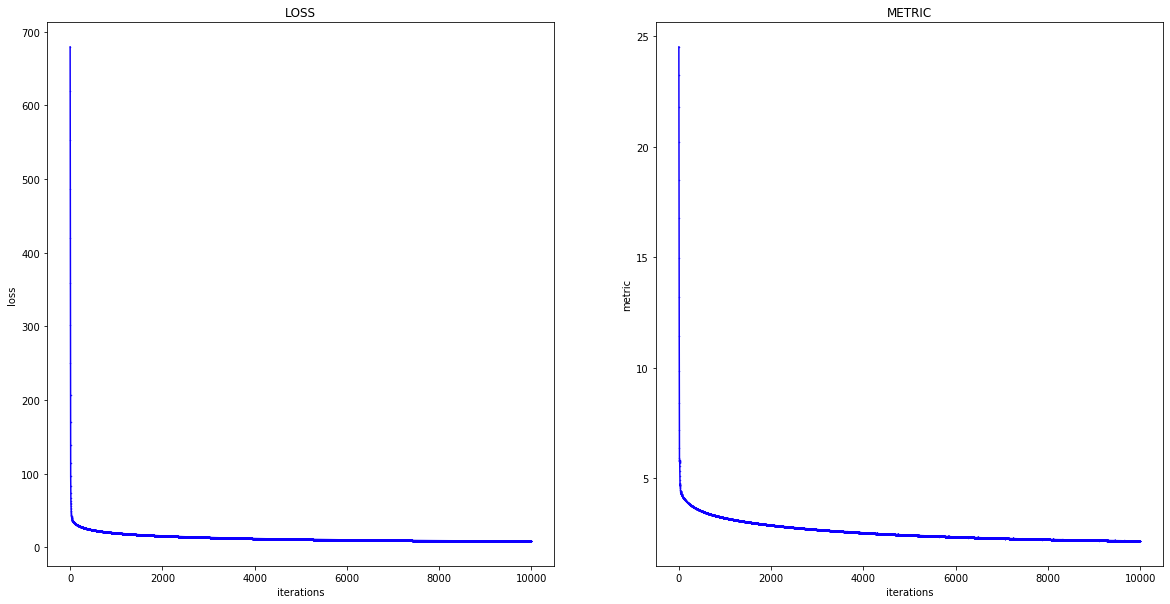

In [14]:
loss = rbf.history['loss']
metric = rbf.history['metric']

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('LOSS')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax1.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='-')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('METRIC')
ax2.set_xlabel('iterations')
ax2.set_ylabel('metric')
ax2.plot(metric, marker='.', color='#0F00FF', markersize=1, linestyle='-')